# Data visualisation

In [39]:
# !pip install kneed

In [40]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Import data

In [41]:
# Set Seaborn style
sns.set(style="whitegrid")

# IMPORT DATA
pat_list = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK017', 'SARK021', 'SARK025', 
            'SARK041', 'SARK011', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK052', 'SARK059']

file_path = 'TCR_sequencing_all_samples_adjusted_20240508.xlsx'

all_df = {}

# # Load the Excel file for each patient
# for i, pat in enumerate(pat_list):
#     sheet_index = (i + 1) * 2 - 2
#     tcr_df = pd.read_excel(file_path, sheet_name=sheet_index, engine='openpyxl')

#     # Remove rows where 'CDR3.amino.acid.sequence' is NaN
#     tcr_df = tcr_df.dropna(subset=['CDR3.amino.acid.sequence'])

#     # Select columns containing '_S'
#     tcr_counts = tcr_df.filter(regex='_S').copy()

#     # Rename columns by extracting the part after '_'
#     tcr_counts.columns = [col.split('_')[1] for col in tcr_counts.columns]

#     # Limit to the first 100 sequences
#     tcr_counts = tcr_counts.head(100)

#     # Drop time steps where all values are NaN (fully missing)
#     tcr_counts = tcr_counts.dropna(axis=1, how="all")

#     # Add an ID column
#     tcr_counts['id'] = ['TCR' + str(j + 1) for j in range(len(tcr_counts))]

#     # Melt the dataframe for plotting
#     tcr_counts_m = tcr_counts.melt(id_vars='id', var_name='time', value_name='counts').copy()

#     # Remove time points where all counts are zero
#     tcr_counts_m = tcr_counts_m[tcr_counts_m['counts'] > 0]

#     # Ensure the time axis contains only valid values for this patient
#     valid_time_steps = sorted(tcr_counts_m['time'].unique(), key=lambda x: int(x[1:]))  # Sort numerically
#     tcr_counts_m['time'] = pd.Categorical(tcr_counts_m['time'], categories=valid_time_steps, ordered=True)

#     all_df[pat]=tcr_counts_m

# Load the Excel file for each patient
for i, pat in enumerate(pat_list):
    sheet_index = (i + 1) * 2 - 2
    tcr_df = pd.read_excel(file_path, sheet_name=sheet_index, engine='openpyxl')

    # Remove rows where 'CDR3.amino.acid.sequence' is NaN
    tcr_df = tcr_df.dropna(subset=['CDR3.amino.acid.sequence'])

    # Select columns containing '_S' (time points)
    tcr_counts = tcr_df.filter(regex='_S').copy()

    # Convert all values to numeric (important for summing later)
    tcr_counts = tcr_counts.apply(pd.to_numeric, errors='coerce')

    # Rename columns by extracting the part after '_'
    tcr_counts.columns = [col.split('_')[1] for col in tcr_counts.columns]

    # Replace missing values with a 0 if the freq data has a 0
    tcr_counts = tcr_counts.where(~(tcr_counts.isna()), 0)

    # Save into tensor. Order by descending order of counts in the first time col. 
    # Mergesort to keep order in case of empate. 
    # Keep 100 highest sequences with most counts
    tcr_counts = tcr_counts.sort_values(by=tcr_counts.columns[0], ascending=False, kind="mergesort").head(100)

    # # Limit to the first 100 sequences
    # tcr_counts = tcr_counts.head(100)

    # Drop time steps where all values are NaN (fully missing)
    tcr_counts = tcr_counts.dropna(axis=1, how="all")

    # Add an ID column
    tcr_counts['id'] = ['TCR' + str(j + 1) for j in range(len(tcr_counts))]

    # Melt the dataframe for plotting
    tcr_counts_m = tcr_counts.melt(id_vars='id', var_name='time', value_name='counts').copy()

    # Ensure 'counts' is numeric
    tcr_counts_m['counts'] = pd.to_numeric(tcr_counts_m['counts'], errors='coerce')

    # Remove time points where all counts are zero
    tcr_counts_m = tcr_counts_m[tcr_counts_m['counts'] > 0]

    # Ensure the time axis contains only valid values for this patient
    valid_time_steps = sorted(tcr_counts_m['time'].unique(), key=lambda x: int(x[1:]))  
    tcr_counts_m['time'] = pd.Categorical(tcr_counts_m['time'], categories=valid_time_steps, ordered=True)

    # Store in dictionary
    all_df[pat] = tcr_counts_m


In [42]:
all_df['SARK012'].head(100)

id time  counts
0     TCR1  S13    81.0
1     TCR2  S13    34.0
2     TCR3  S13    34.0
3     TCR4  S13    18.0
4     TCR5  S13    16.0
..     ...  ...     ...
108   TCR9  S14     3.0
109  TCR10  S14    14.0
110  TCR11  S14    10.0
111  TCR12  S14     8.0
112  TCR13  S14     4.0

[100 rows x 3 columns]

## Line plots

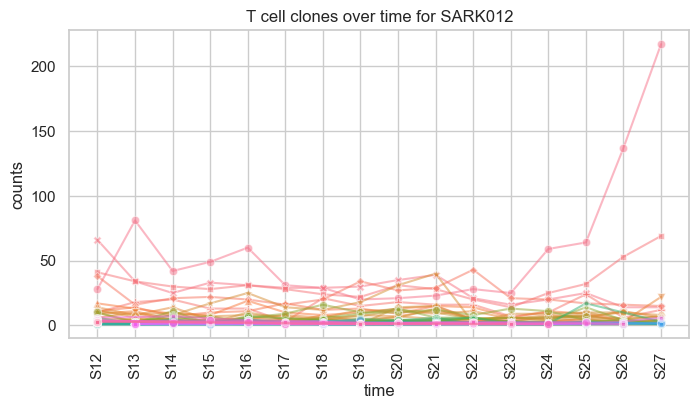

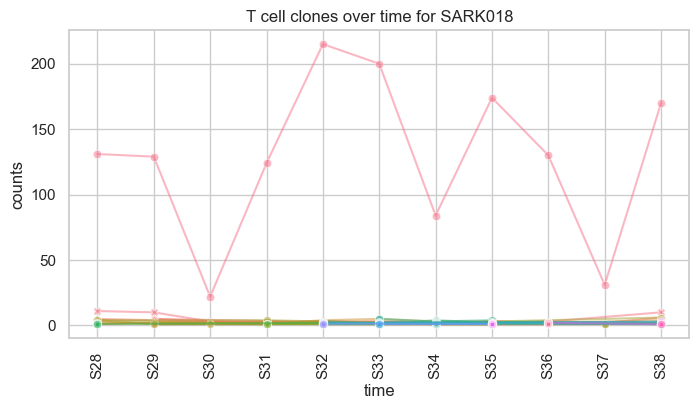

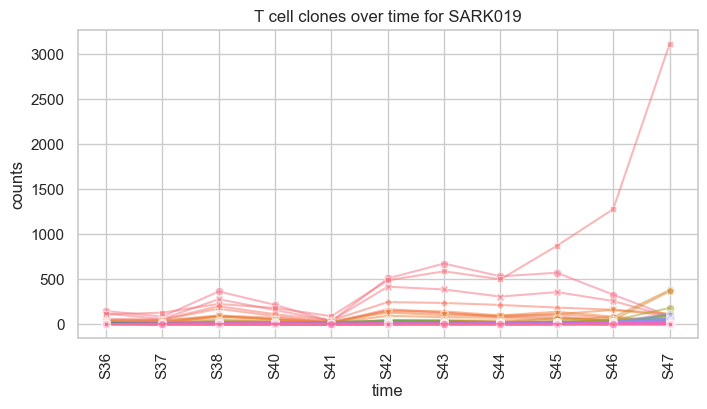

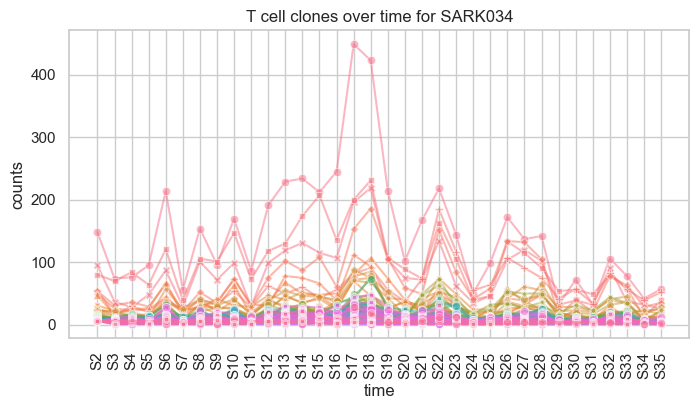

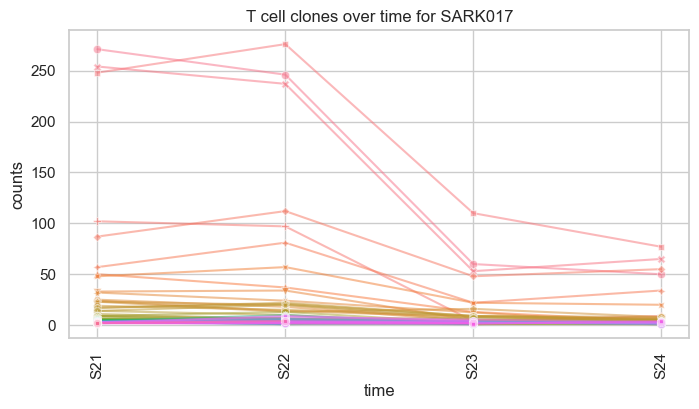

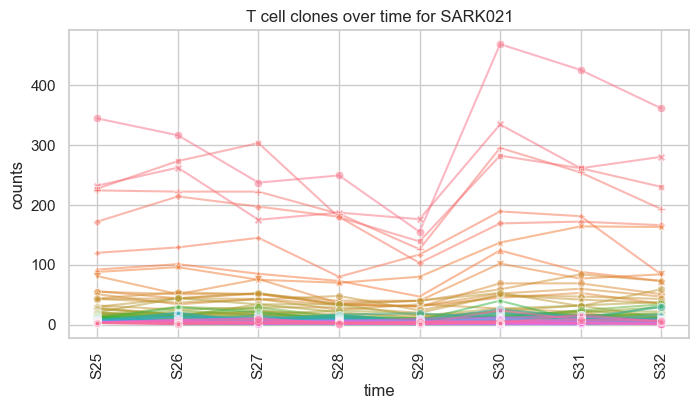

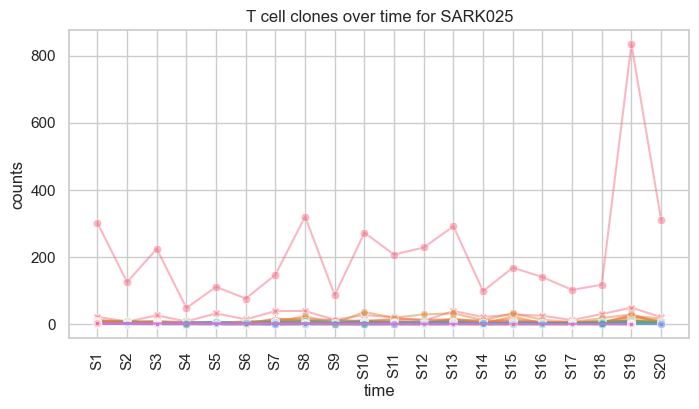

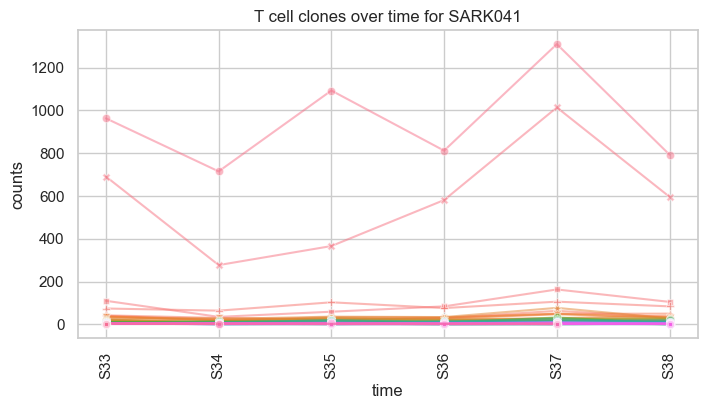

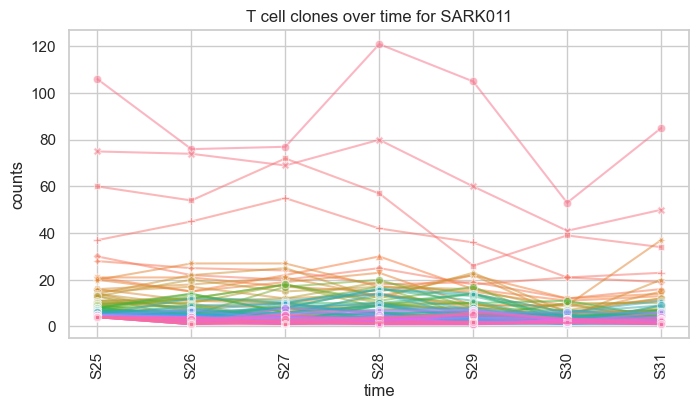

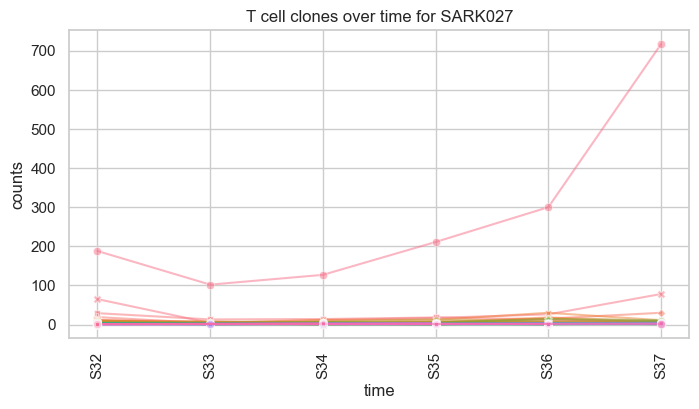

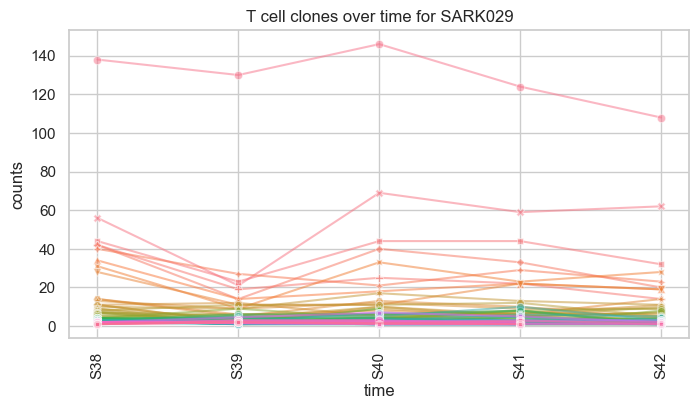

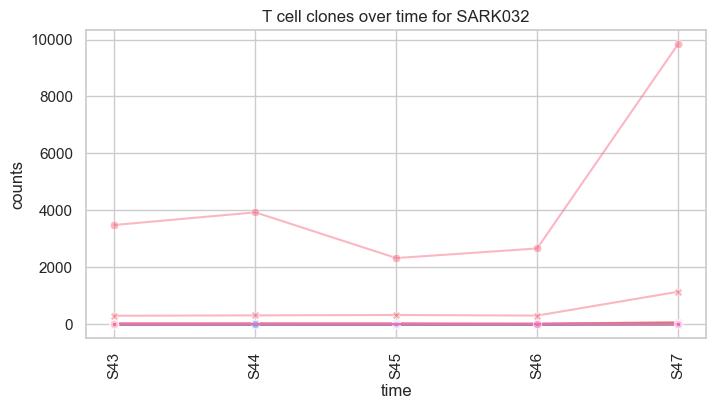

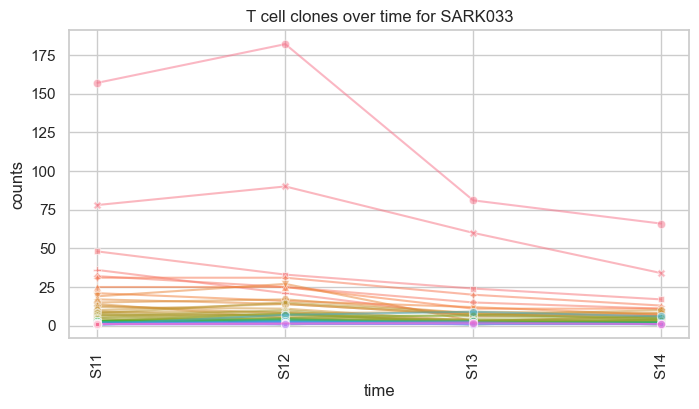

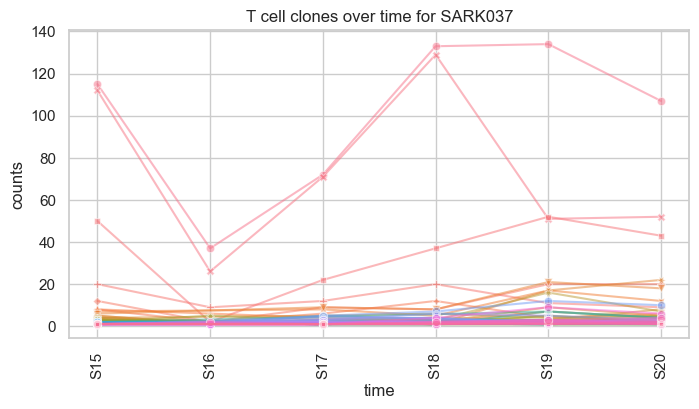

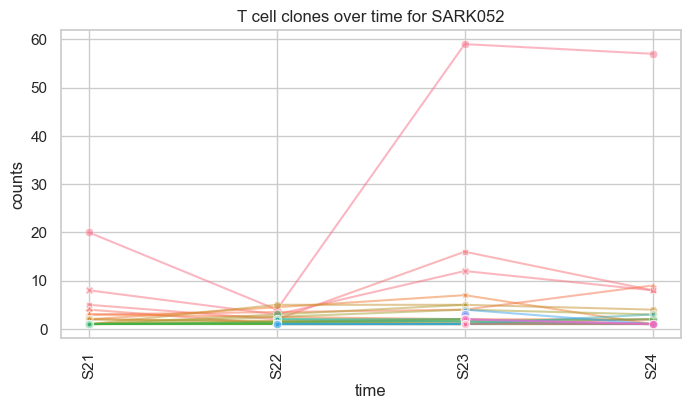

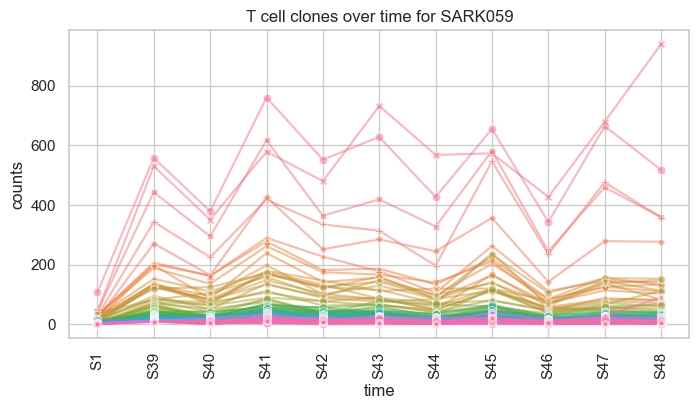

In [43]:
# Set Seaborn style
sns.set(style="whitegrid")

for pat, df in all_df.items():
    # Plot: Line Plot without empty time steps
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df, x='time', y='counts', hue='id', style='id', markers=True, dashes=False, alpha=0.5)
    plt.xticks(rotation=90)
    plt.title(f'T cell clones over time for {pat}')
    plt.legend().remove()  # Prevent legend clutter
    plt.show()


## Histogram

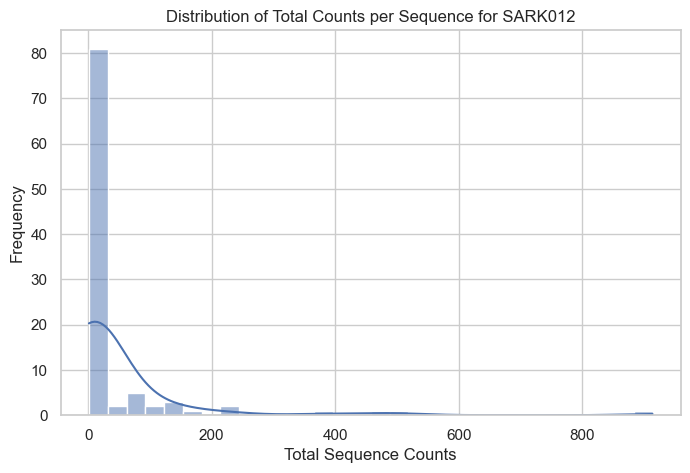

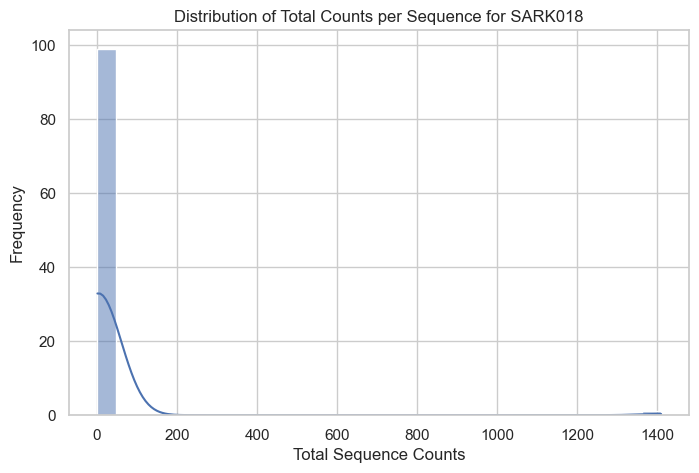

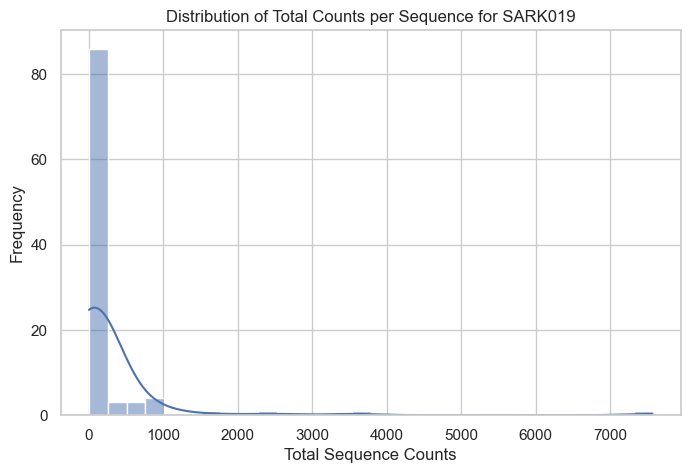

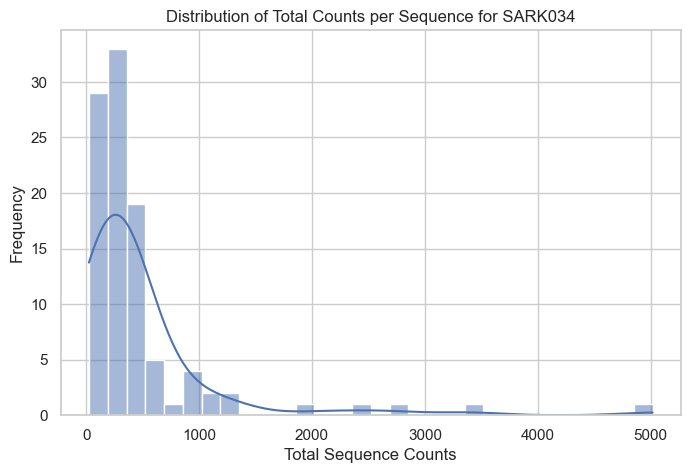

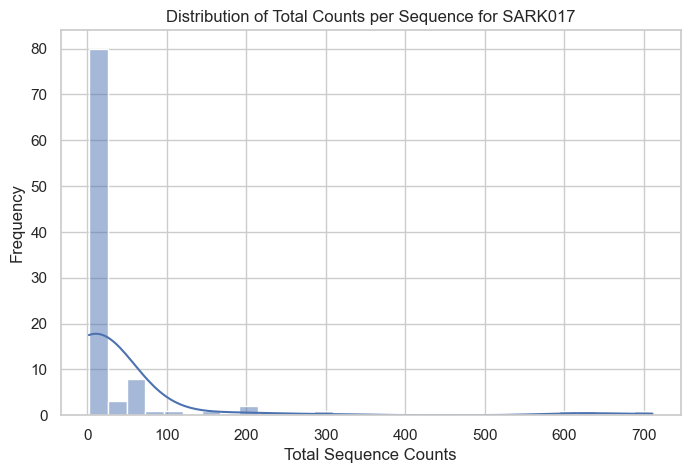

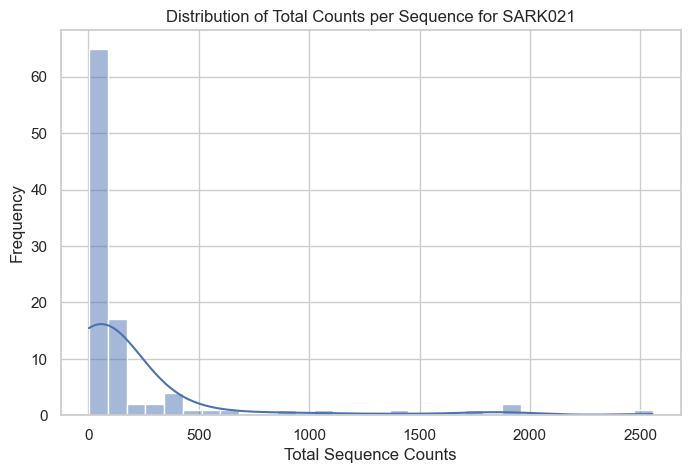

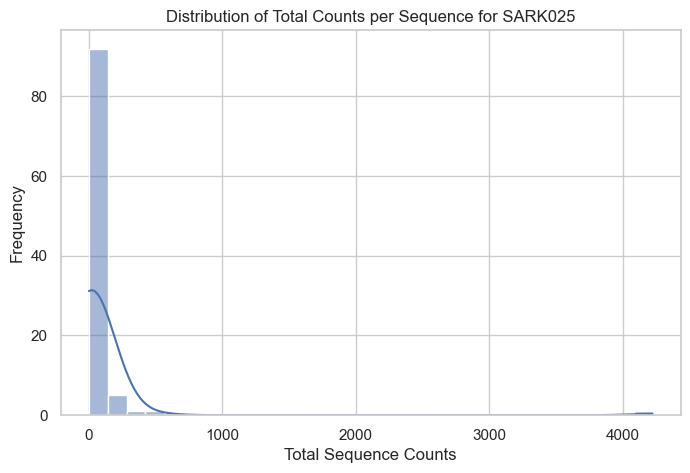

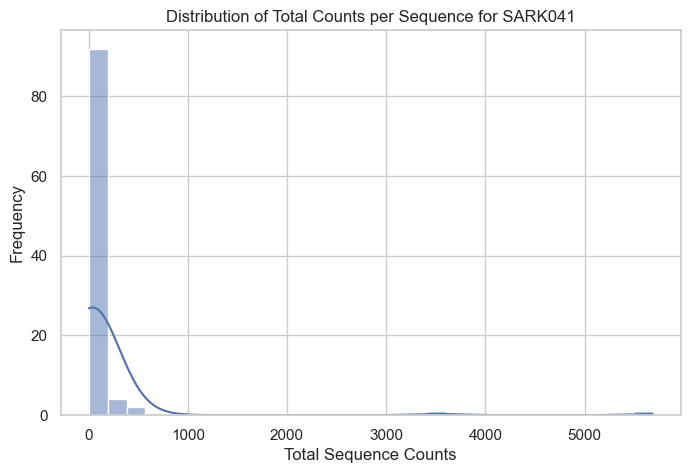

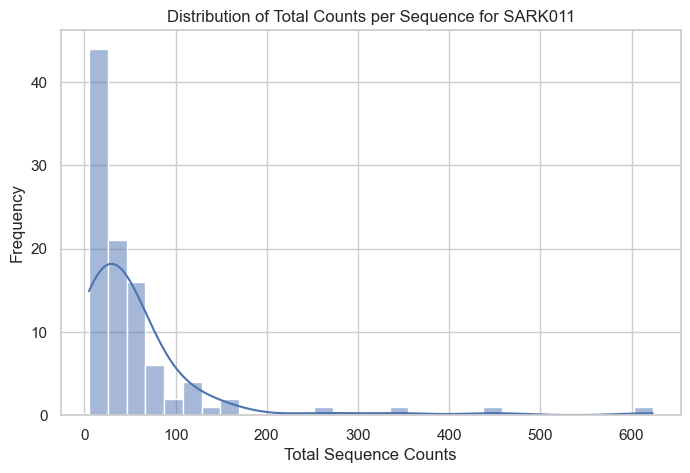

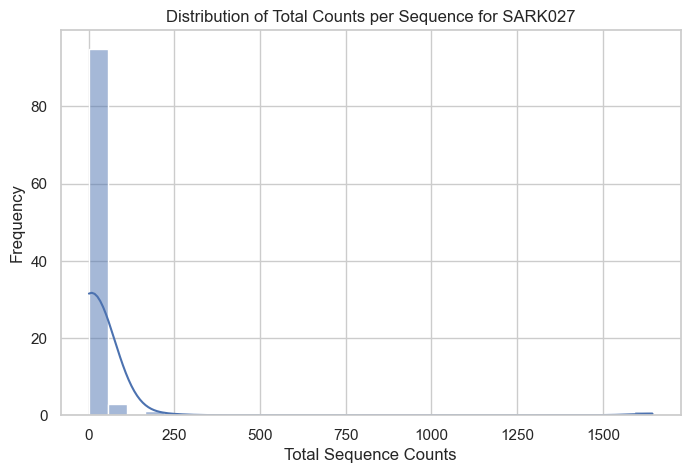

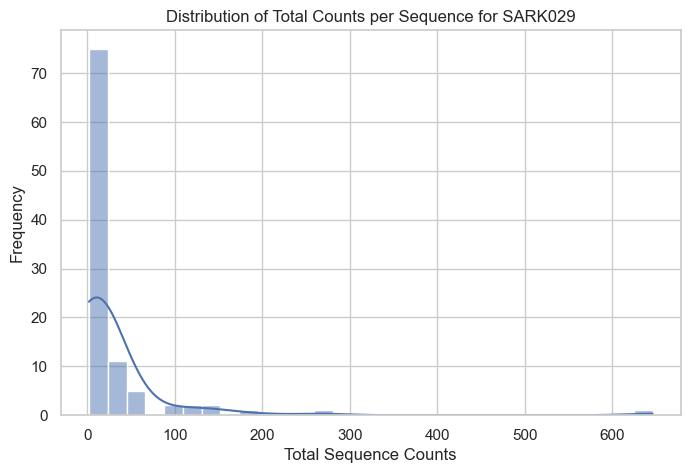

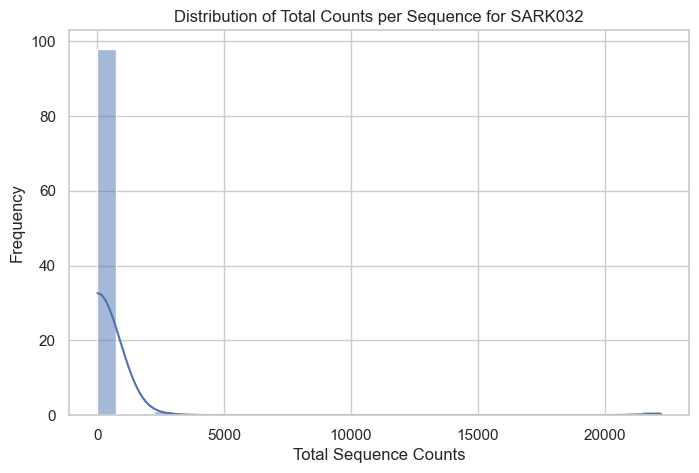

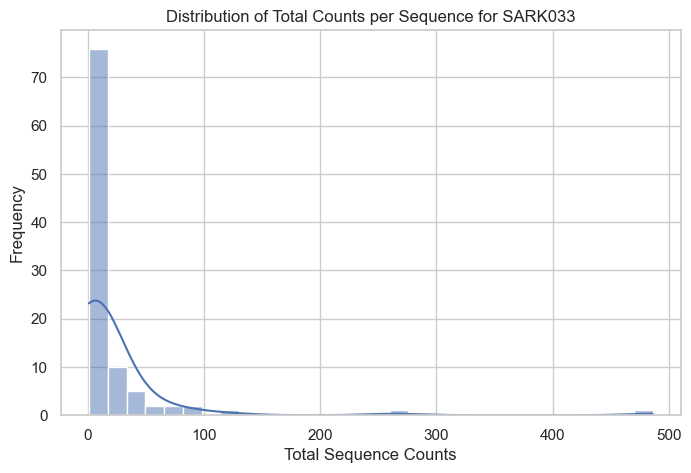

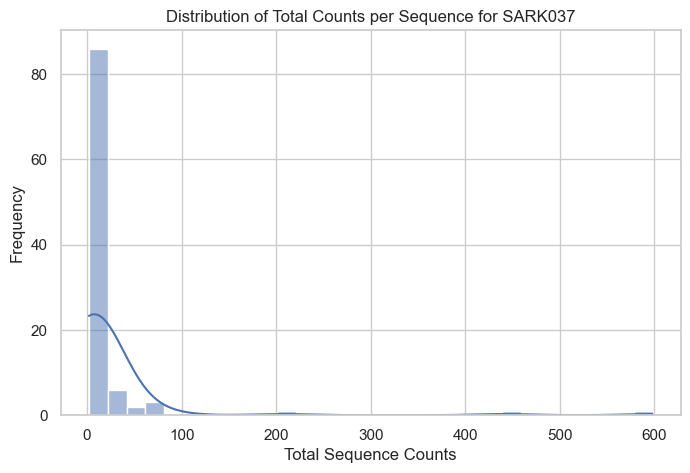

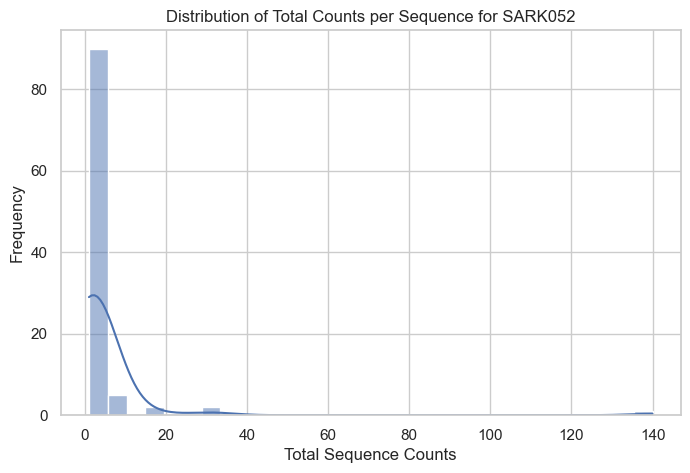

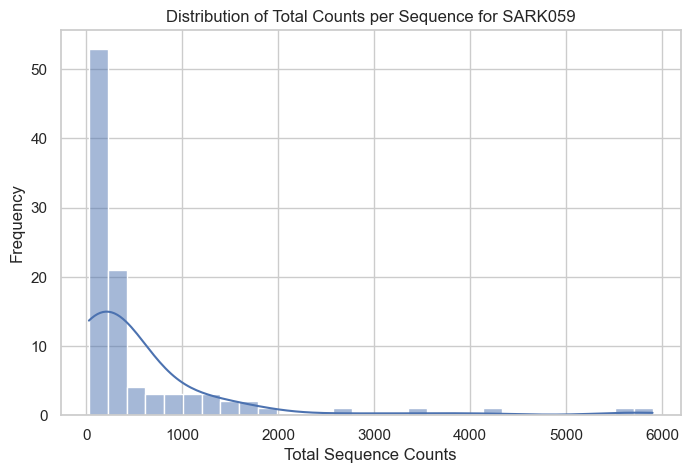

In [44]:
# Plot 2: Histograms
for pat, df in all_df.items():
    if df.empty:
        print(f"Skipping {pat} due to empty dataframe.")
        continue

    # Sum only the 'counts' column grouped by 'id'
    sequence_totals = df.groupby('id')['counts'].sum()

    # Histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(sequence_totals, bins=30, kde=True)
    plt.xlabel("Total Sequence Counts")
    plt.ylabel("Frequency")
    plt.title(f'Distribution of Total Counts per Sequence for {pat}')
    plt.show()


## Log scale Hist

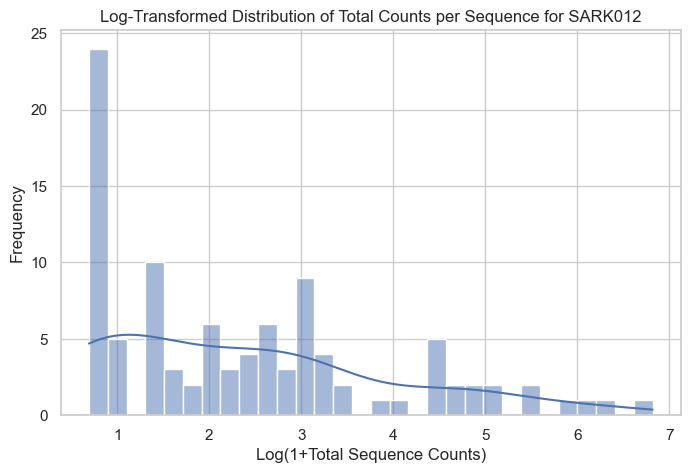

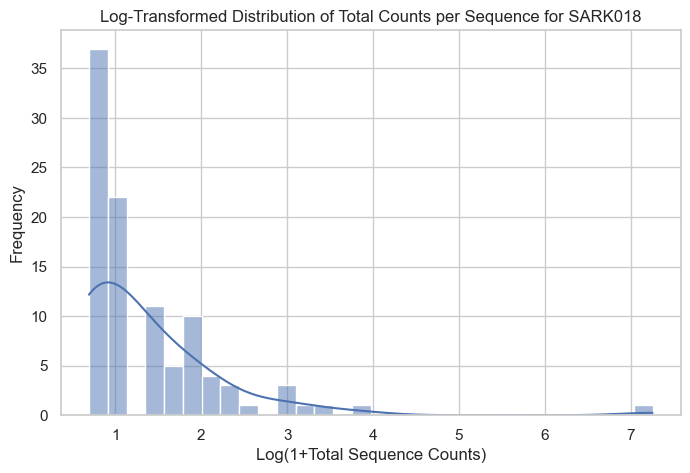

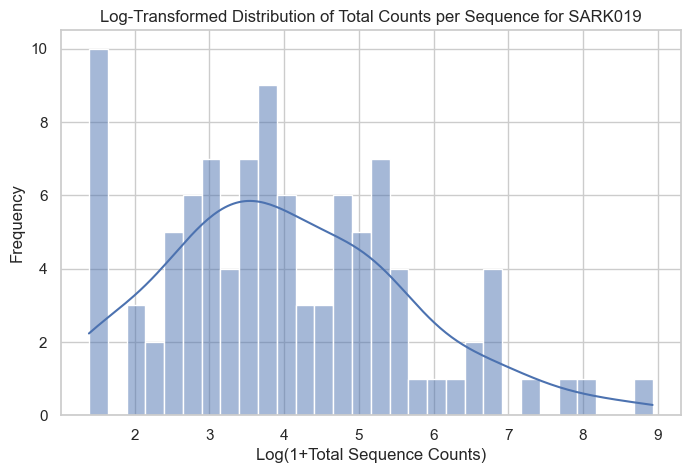

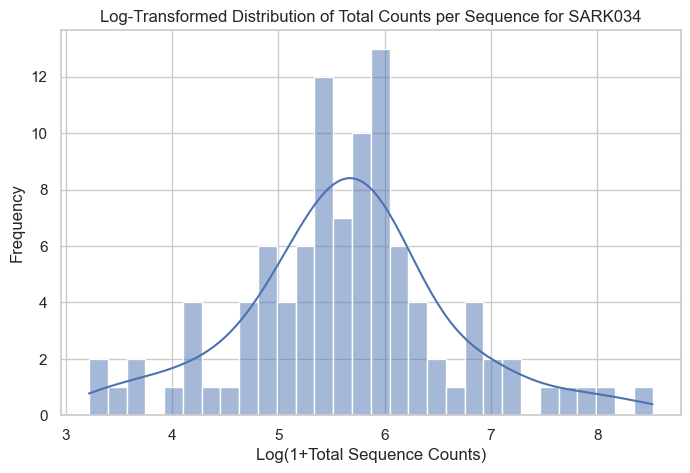

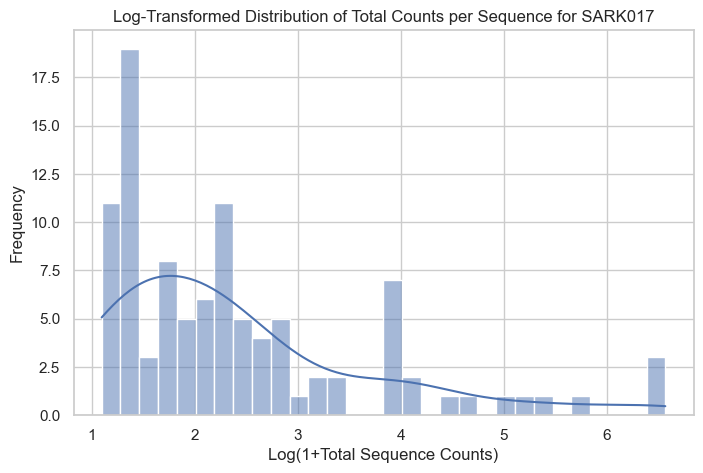

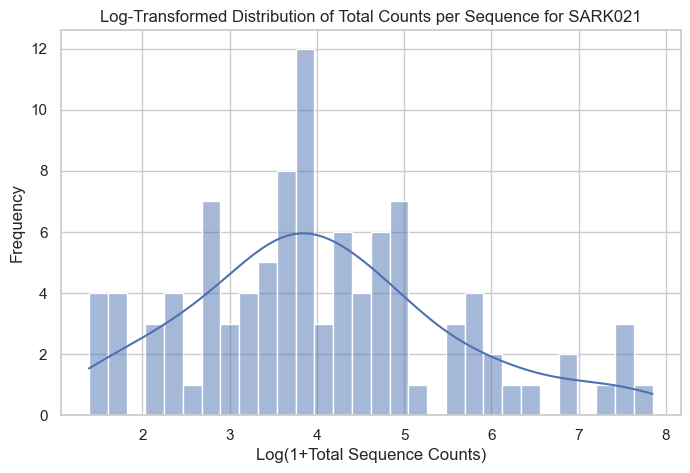

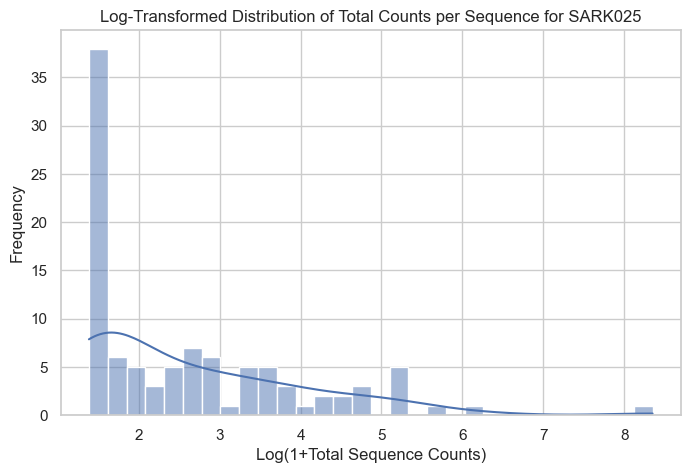

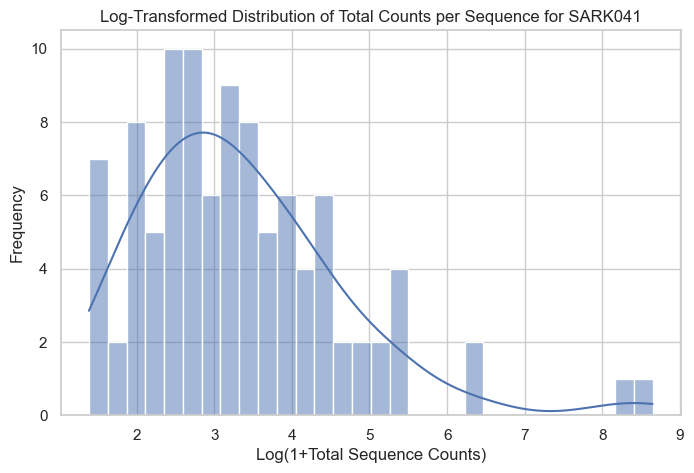

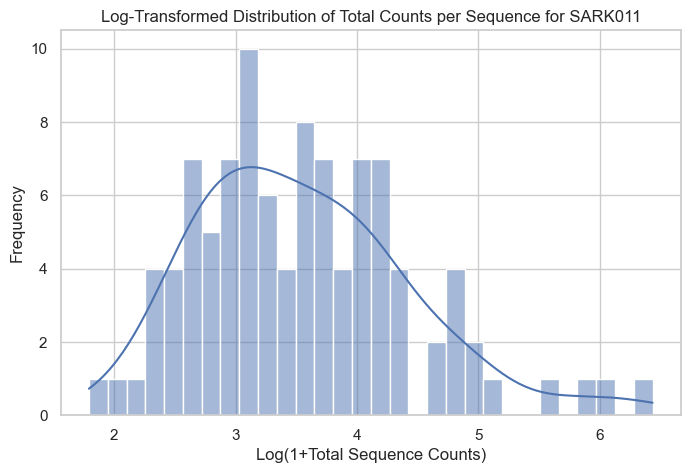

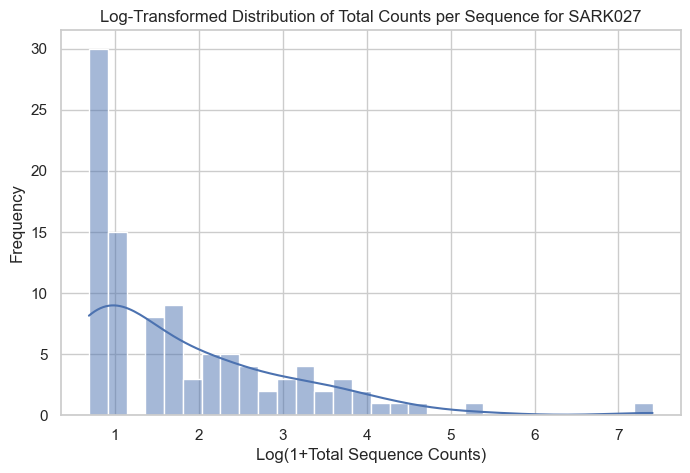

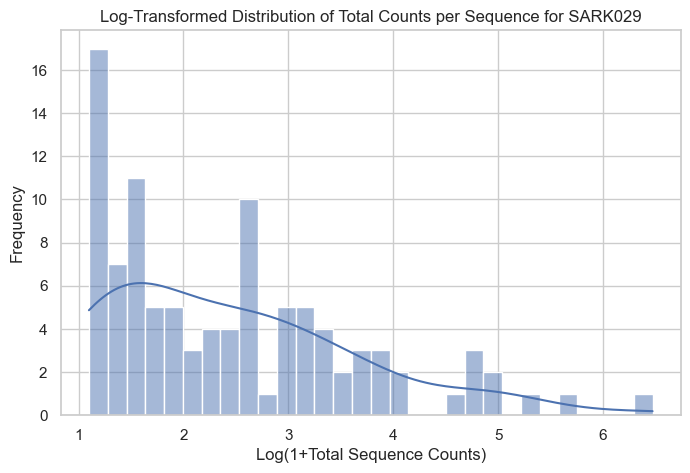

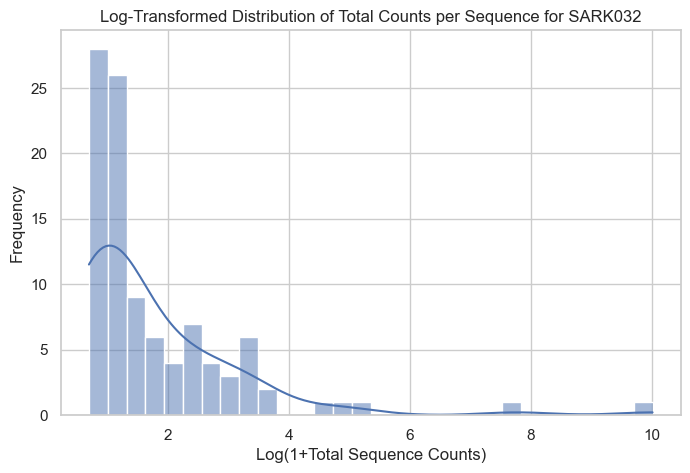

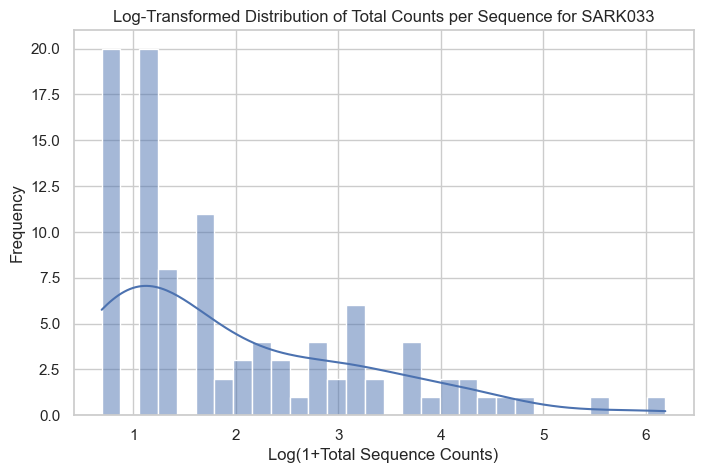

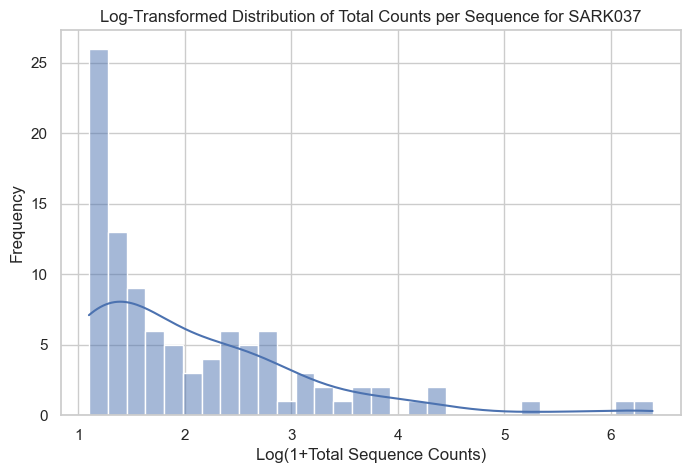

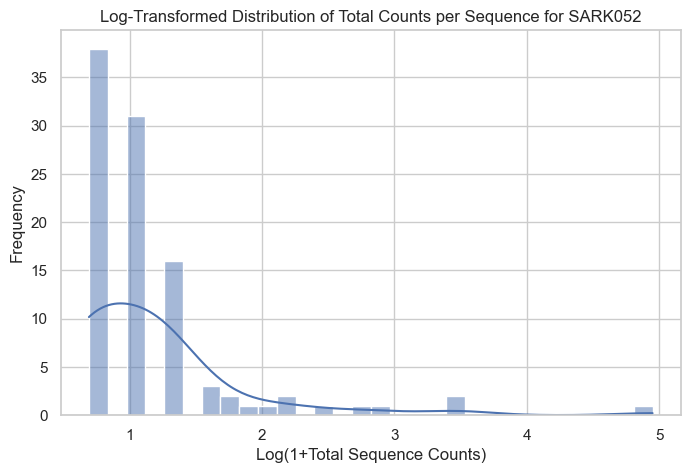

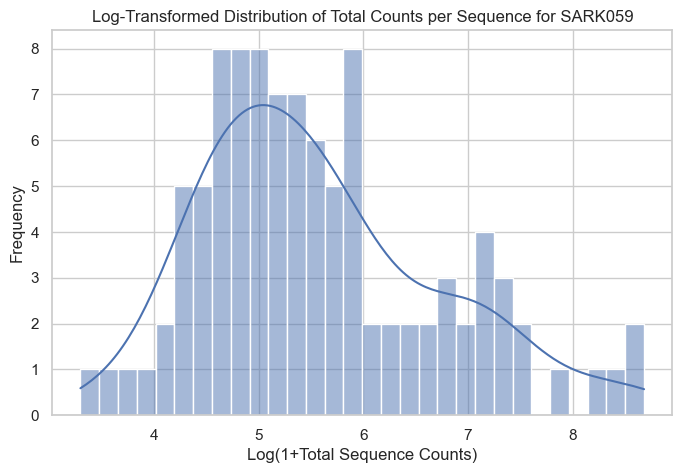

In [45]:
# Plot 3: Log-scale Histograms
for pat, df in all_df.items():
    if df.empty:
        print(f"Skipping {pat} due to empty dataframe.")
        continue

    # Sum only the 'counts' column grouped by 'id'
    sequence_totals = df.groupby('id')['counts'].sum()

    # Histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(np.log1p(sequence_totals), bins=30, kde=True)
    plt.xlabel("Log(1+Total Sequence Counts)")
    plt.ylabel("Frequency")
    plt.title(f'Log-Transformed Distribution of Total Counts per Sequence for {pat}')
    plt.show()


## Heatmaps over time

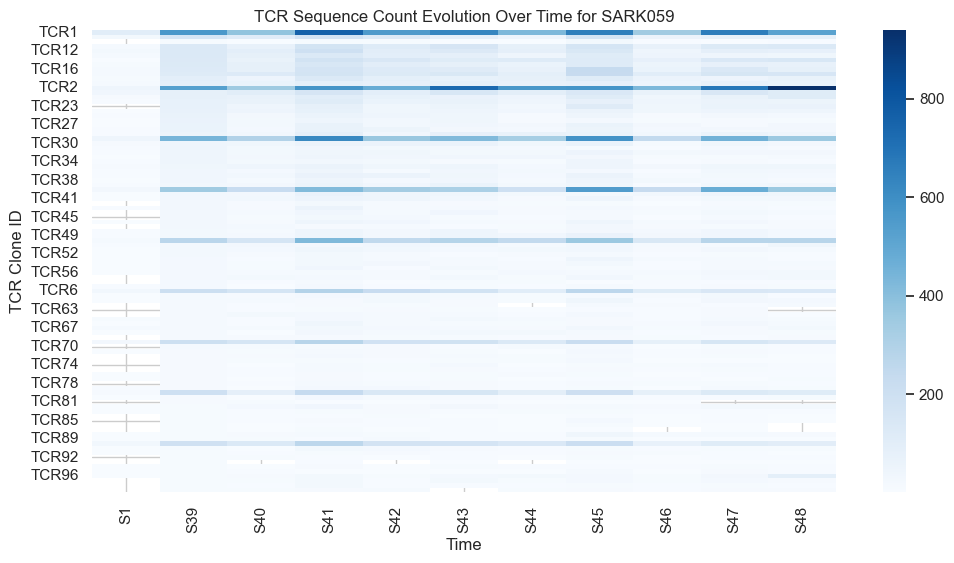

In [46]:

# Extract data for this patient
df = all_df['SARK059']

# Pivot data to make a heatmap-friendly format
heatmap_data = df.pivot(index="id", columns="time", values="counts")

# Set a minimum threshold to avoid small floating-point artifacts
heatmap_data[heatmap_data < 1] = 0  # Forces values below 1 to be zero

# Replot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="Blues", linewidths=0, linecolor=None, cbar=True)

plt.xlabel("Time")
plt.ylabel("TCR Clone ID")
plt.title("TCR Sequence Count Evolution Over Time for SARK059")
plt.xticks(rotation=90)
plt.show()




## Boxplot

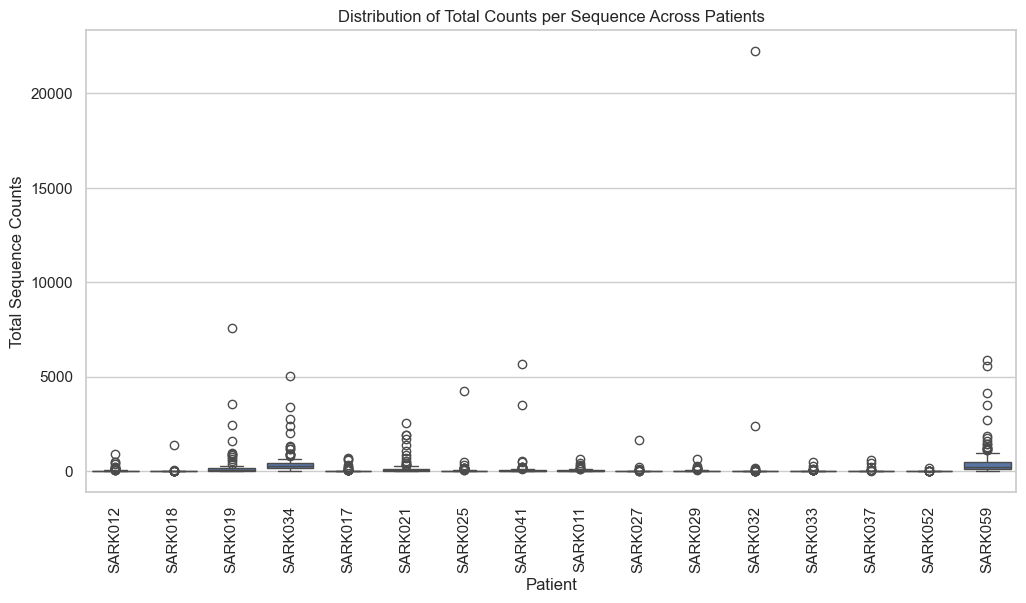

In [47]:
# Combine data across all patients
boxplot_data = []

for pat, df in all_df.items():
    if df.empty:
        print(f"Skipping {pat} due to empty dataframe.")
        continue

    sequence_totals = df.groupby('id')['counts'].sum()
    for value in sequence_totals:
        boxplot_data.append({'Patient': pat, 'Total Counts': value})

# Convert to DataFrame for Seaborn
boxplot_df = pd.DataFrame(boxplot_data)

# Boxplot with patients as categories
plt.figure(figsize=(12, 6))
sns.boxplot(x='Patient', y='Total Counts', data=boxplot_df)
plt.xticks(rotation=90)  # Rotate patient labels for readability
plt.xlabel("Patient")
plt.ylabel("Total Sequence Counts")
plt.title("Distribution of Total Counts per Sequence Across Patients")
plt.show()


C:\Users\viola\AppData\Local\Temp\ipykernel_25008\3038552804.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(np.expm1(y)):,}" for y in yticks])  # Convert back and format with commas


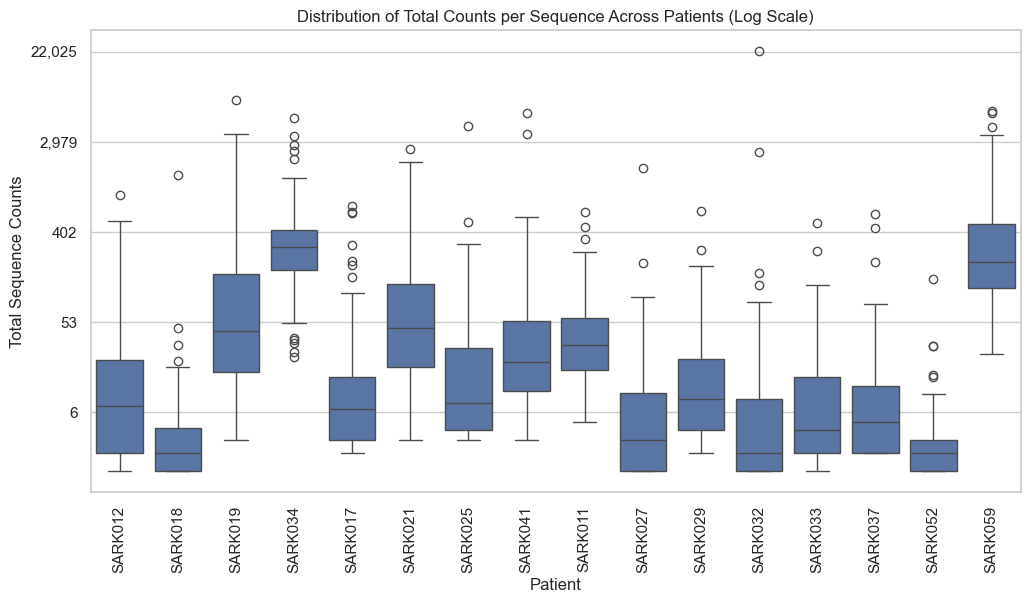

In [ ]:
# Convert 'Total Counts' to log scale
boxplot_df['Log Total Counts'] = np.log1p(boxplot_df['Total Counts'])

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Patient', y='Log Total Counts', data=boxplot_df)

# Convert y-axis ticks back to original scale
yticks = ax.get_yticks()
ax.set_yticklabels([f"{int(np.expm1(y)):,}" for y in yticks])  # Convert back and format with commas

# Formatting
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.xlabel("Patient")
plt.ylabel("Total Sequence Counts")
plt.title("Distribution of Total Counts per Sequence Across Patients (Log Transformed)")

plt.show()

### Each pat

C:\Users\viola\AppData\Local\Temp\ipykernel_25008\309109791.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(np.expm1(y)):,}" for y in yticks])  # Convert back to original scale


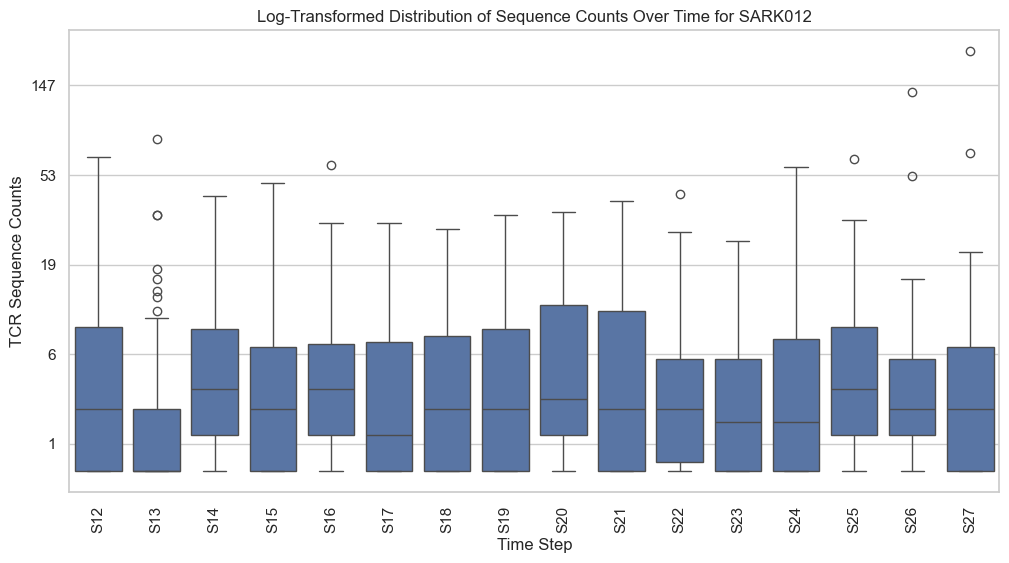

C:\Users\viola\AppData\Local\Temp\ipykernel_25008\309109791.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(np.expm1(y)):,}" for y in yticks])  # Convert back to original scale


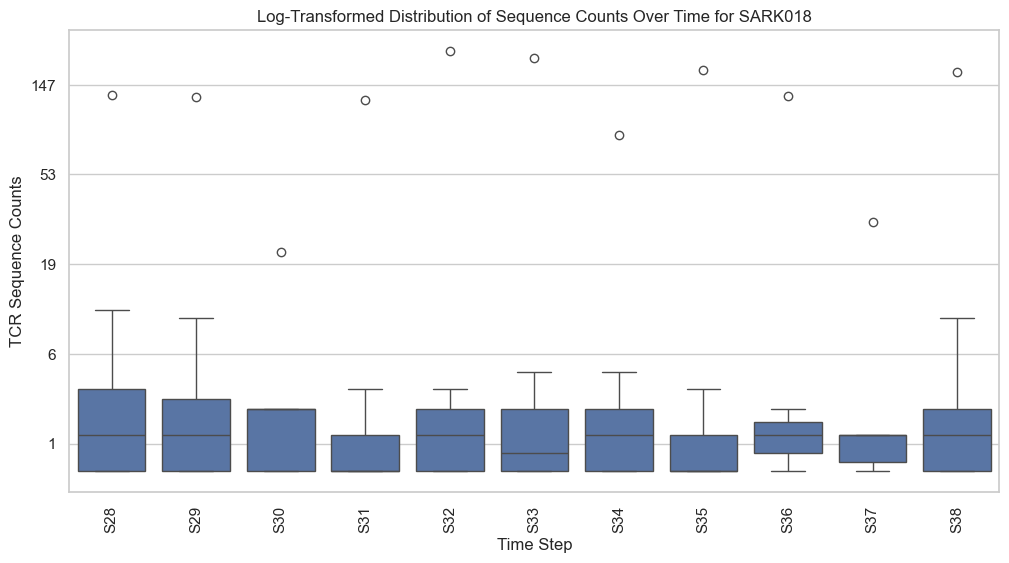

C:\Users\viola\AppData\Local\Temp\ipykernel_25008\309109791.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(np.expm1(y)):,}" for y in yticks])  # Convert back to original scale


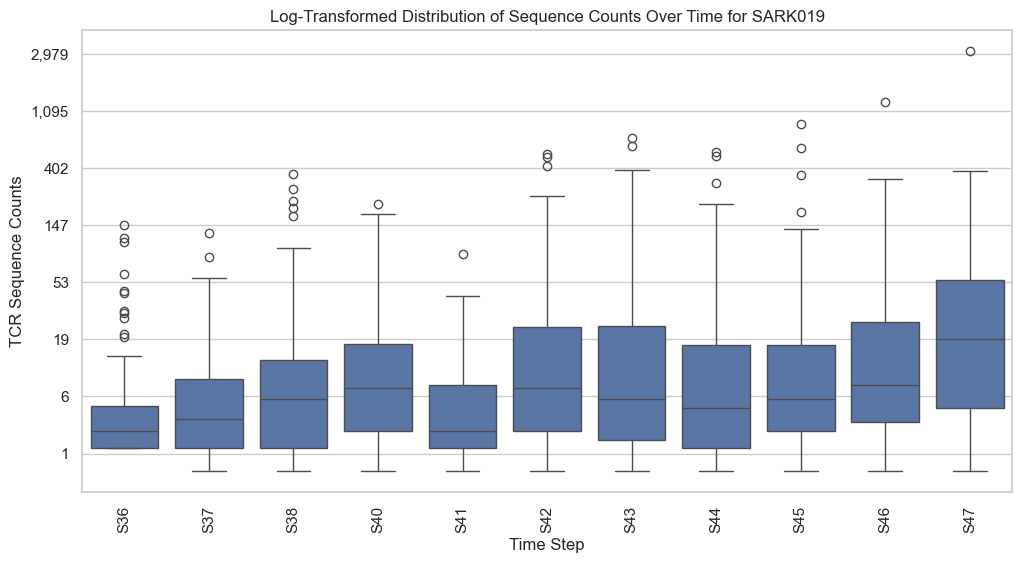

C:\Users\viola\AppData\Local\Temp\ipykernel_25008\309109791.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(np.expm1(y)):,}" for y in yticks])  # Convert back to original scale


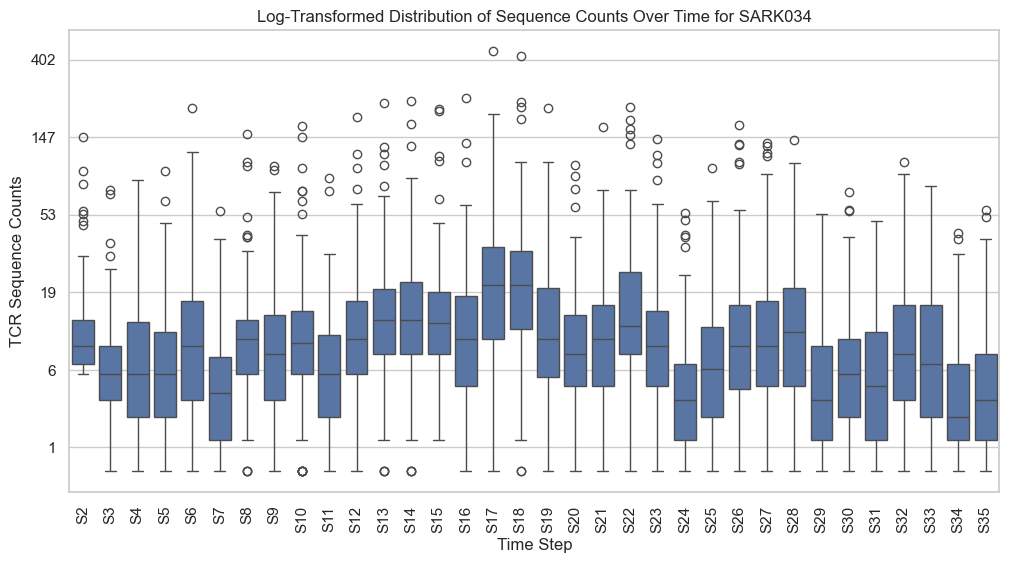

C:\Users\viola\AppData\Local\Temp\ipykernel_25008\309109791.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(np.expm1(y)):,}" for y in yticks])  # Convert back to original scale


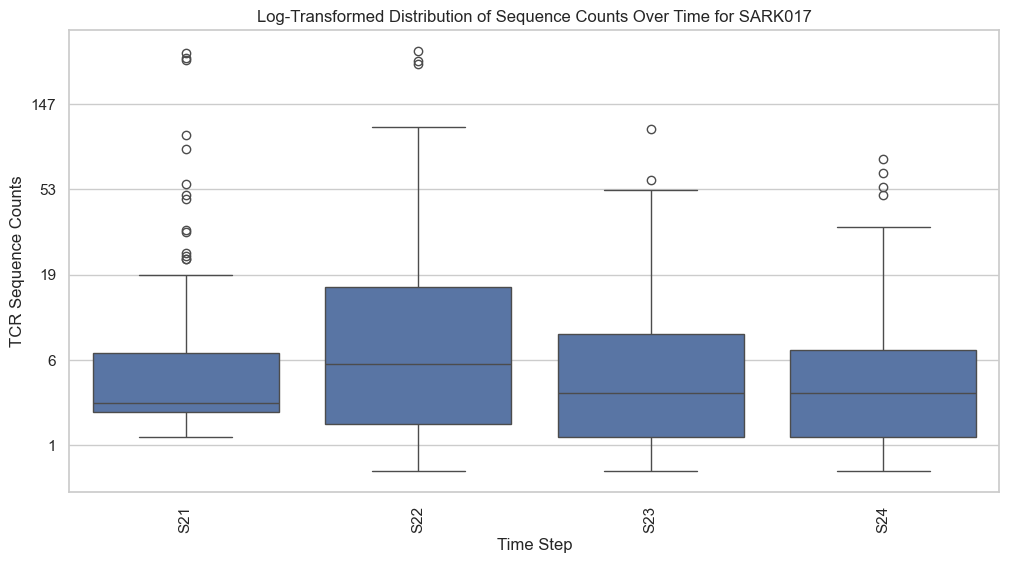

C:\Users\viola\AppData\Local\Temp\ipykernel_25008\309109791.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(np.expm1(y)):,}" for y in yticks])  # Convert back to original scale


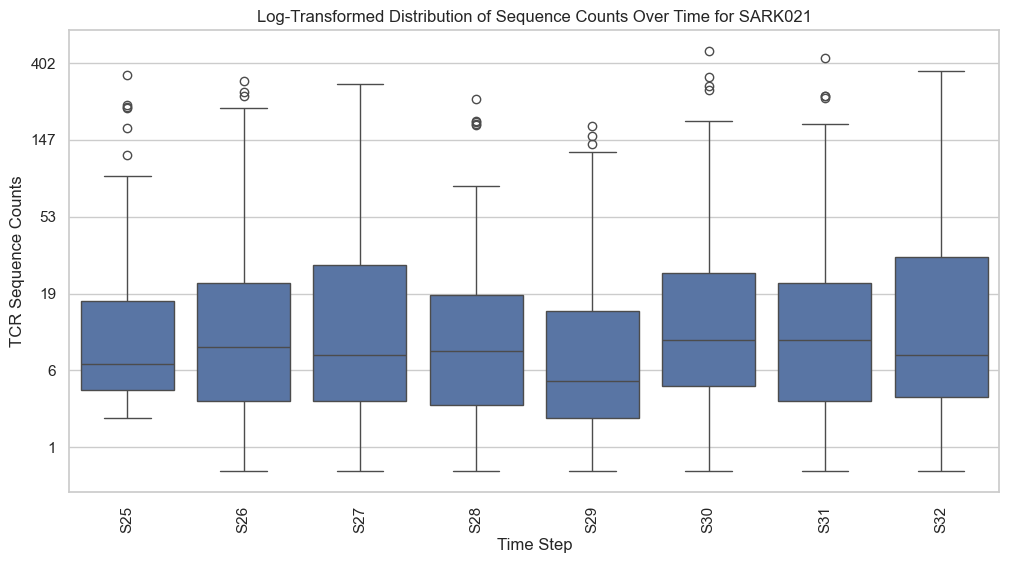

C:\Users\viola\AppData\Local\Temp\ipykernel_25008\309109791.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(np.expm1(y)):,}" for y in yticks])  # Convert back to original scale


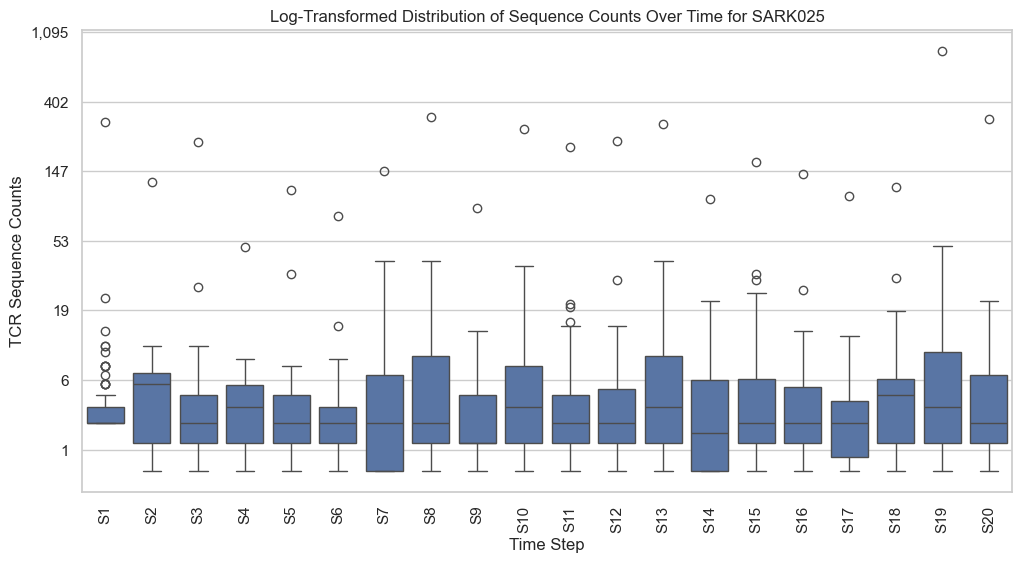

C:\Users\viola\AppData\Local\Temp\ipykernel_25008\309109791.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(np.expm1(y)):,}" for y in yticks])  # Convert back to original scale


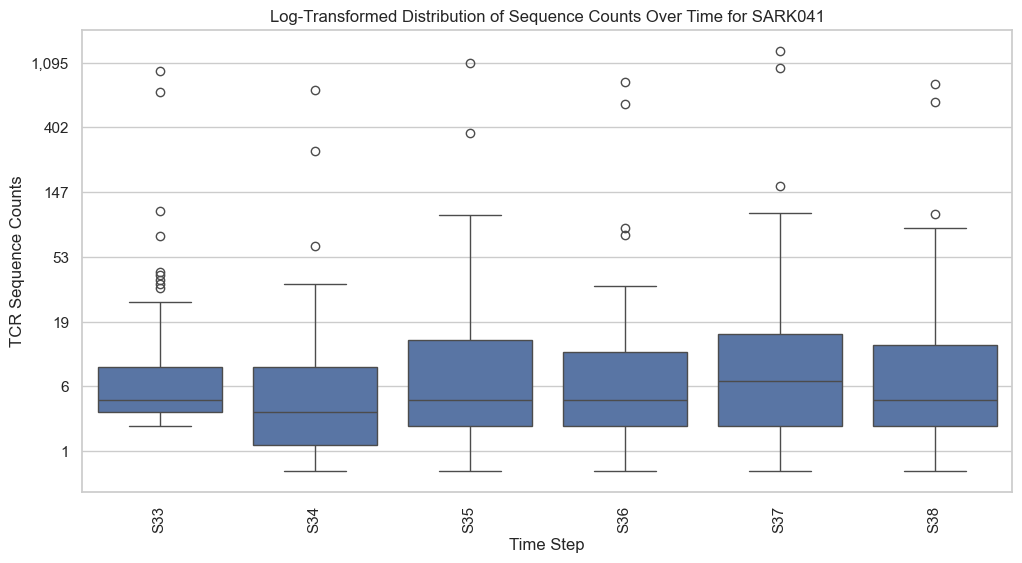

C:\Users\viola\AppData\Local\Temp\ipykernel_25008\309109791.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(np.expm1(y)):,}" for y in yticks])  # Convert back to original scale


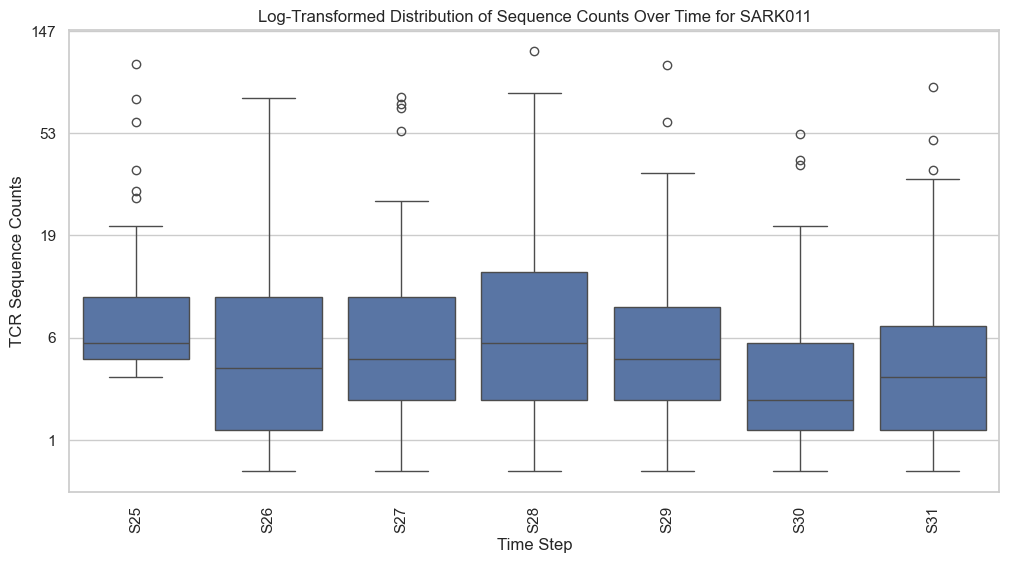

C:\Users\viola\AppData\Local\Temp\ipykernel_25008\309109791.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(np.expm1(y)):,}" for y in yticks])  # Convert back to original scale


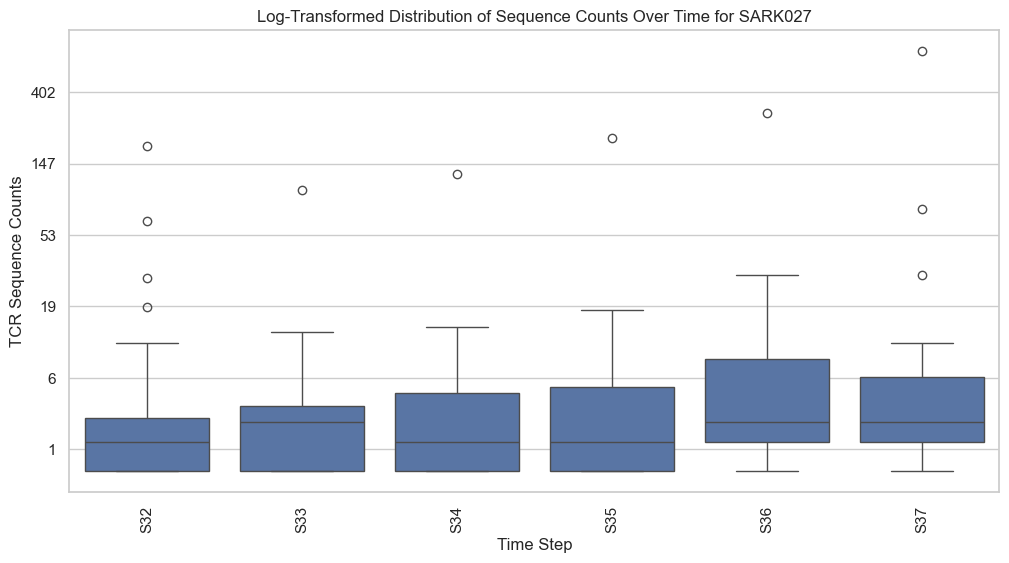

C:\Users\viola\AppData\Local\Temp\ipykernel_25008\309109791.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(np.expm1(y)):,}" for y in yticks])  # Convert back to original scale


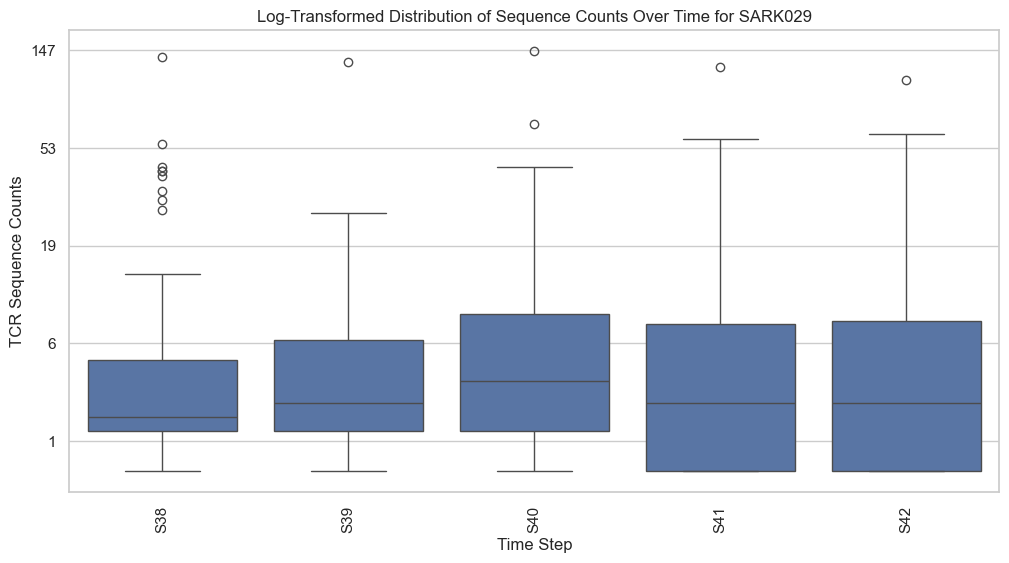

C:\Users\viola\AppData\Local\Temp\ipykernel_25008\309109791.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(np.expm1(y)):,}" for y in yticks])  # Convert back to original scale


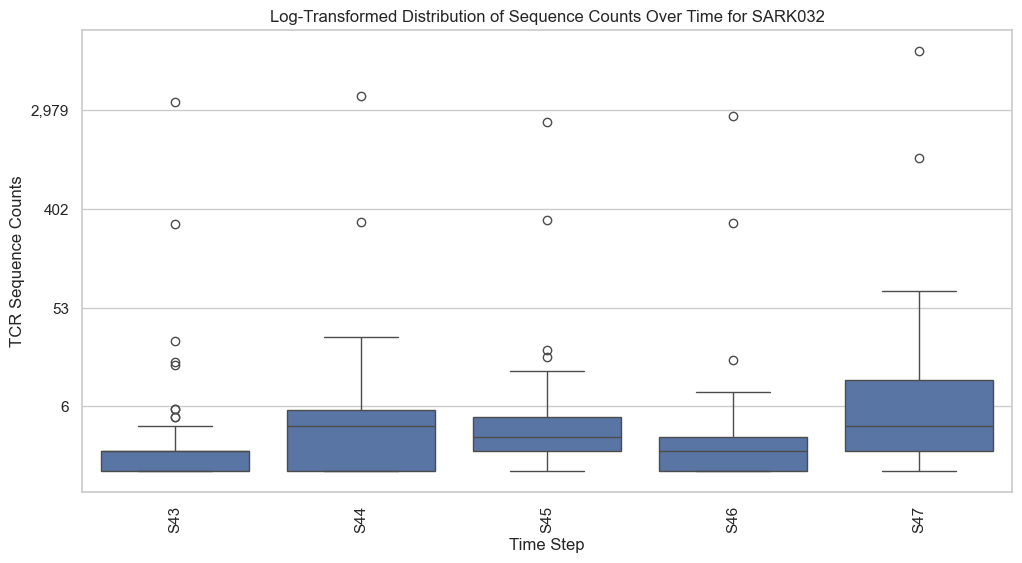

C:\Users\viola\AppData\Local\Temp\ipykernel_25008\309109791.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(np.expm1(y)):,}" for y in yticks])  # Convert back to original scale


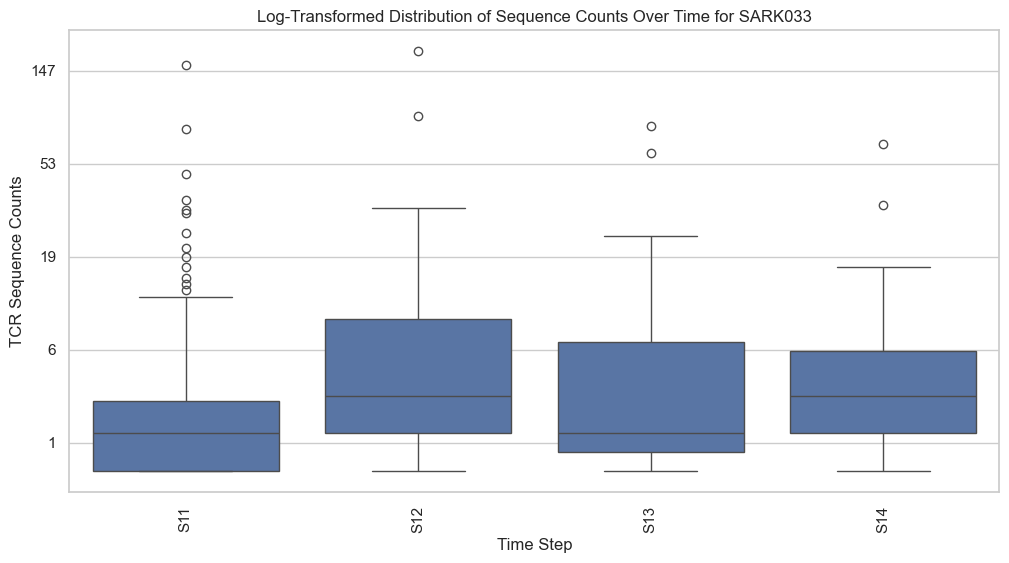

C:\Users\viola\AppData\Local\Temp\ipykernel_25008\309109791.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(np.expm1(y)):,}" for y in yticks])  # Convert back to original scale


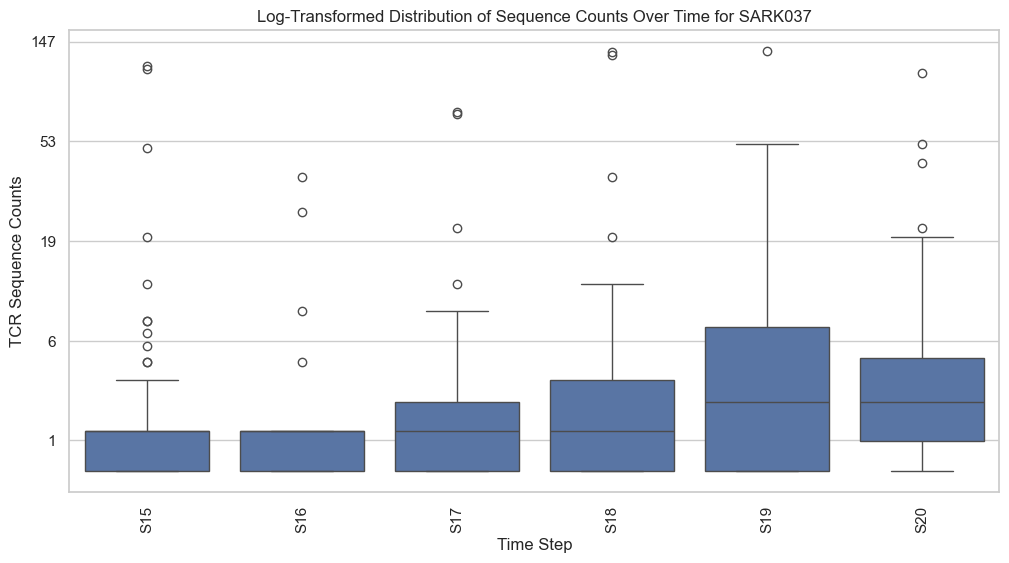

C:\Users\viola\AppData\Local\Temp\ipykernel_25008\309109791.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(np.expm1(y)):,}" for y in yticks])  # Convert back to original scale


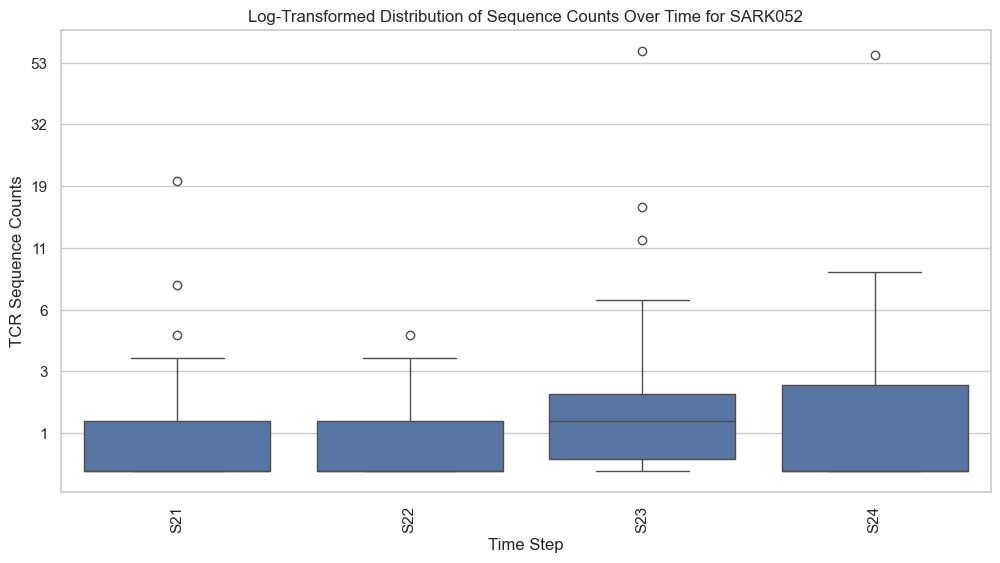

C:\Users\viola\AppData\Local\Temp\ipykernel_25008\309109791.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(np.expm1(y)):,}" for y in yticks])  # Convert back to original scale


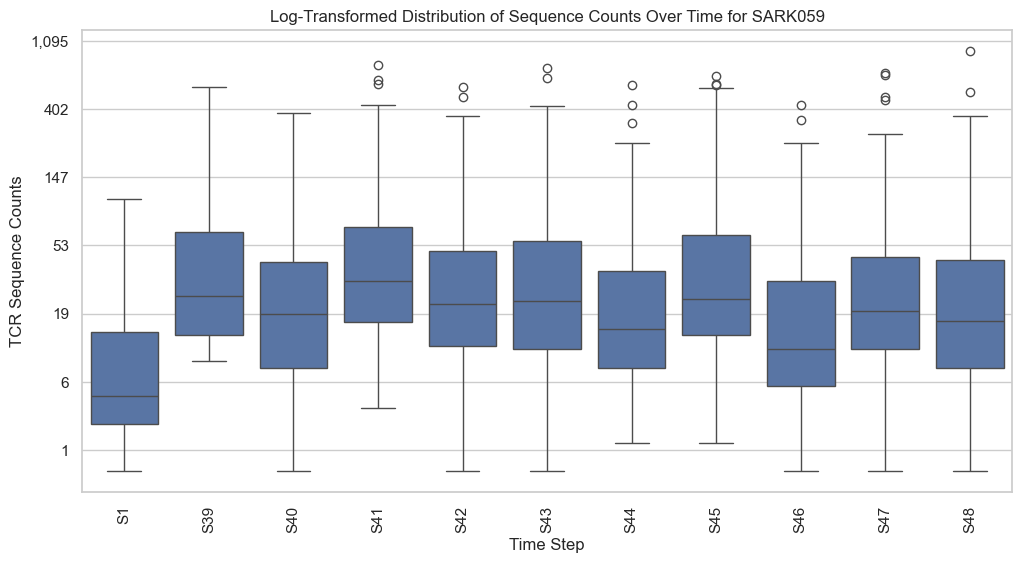

In [53]:
for pat, df in all_df.items():
    if df.empty:
        print(f"Skipping {pat} due to empty dataframe.")
        continue

    # Ensure time is treated as categorical for ordering
    df['time'] = pd.Categorical(df['time'], ordered=True)

    # Apply log transformation to counts
    df['log_counts'] = np.log1p(df['counts'])  # log1p avoids issues with zero values

    # Create figure
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(x='time', y='log_counts', data=df)

    # Convert y-axis tick labels back to original scale
    yticks = ax.get_yticks()
    ax.set_yticklabels([f"{int(np.expm1(y)):,}" for y in yticks])  # Convert back to original scale

    # Formatting
    plt.xticks(rotation=90)
    plt.xlabel("Time Step")
    plt.ylabel("TCR Sequence Counts")
    plt.title(f"Log-Transformed Distribution of Sequence Counts Over Time for {pat}")

    plt.show()


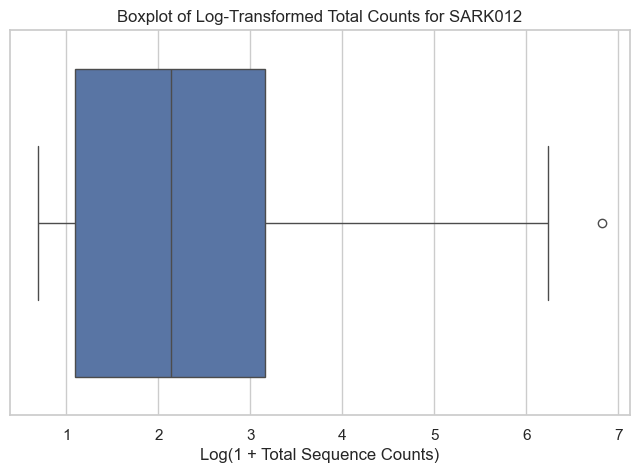

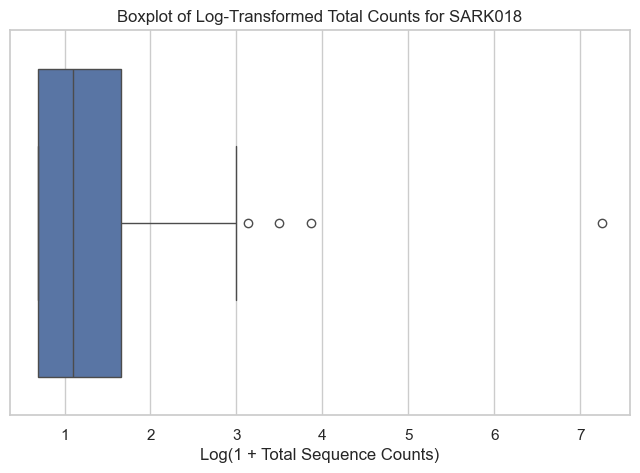

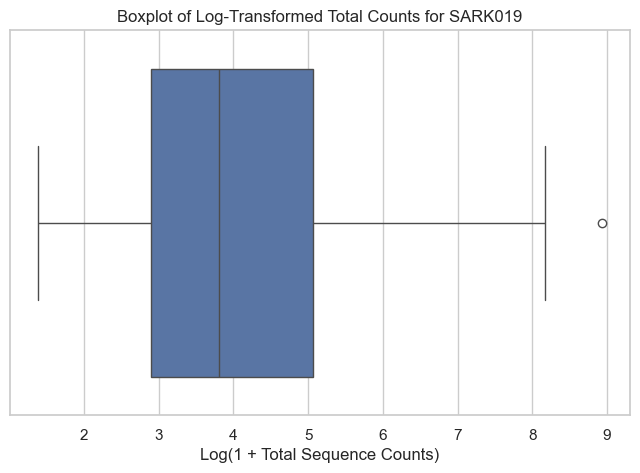

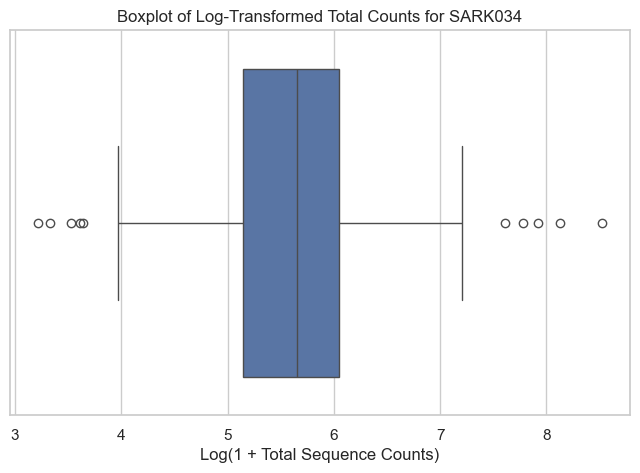

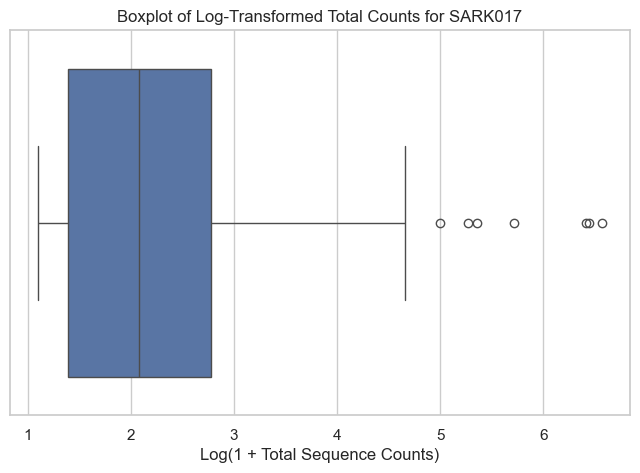

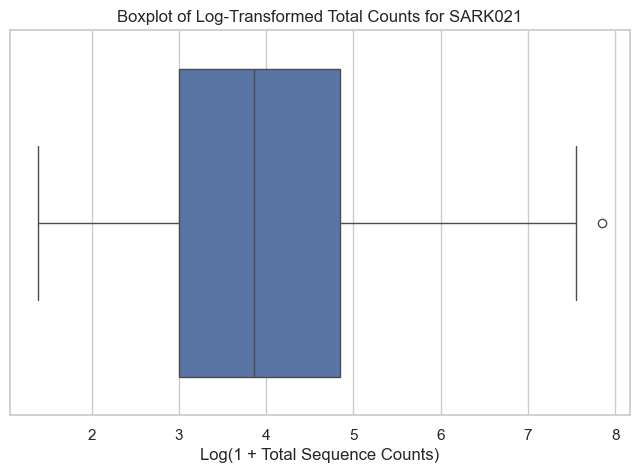

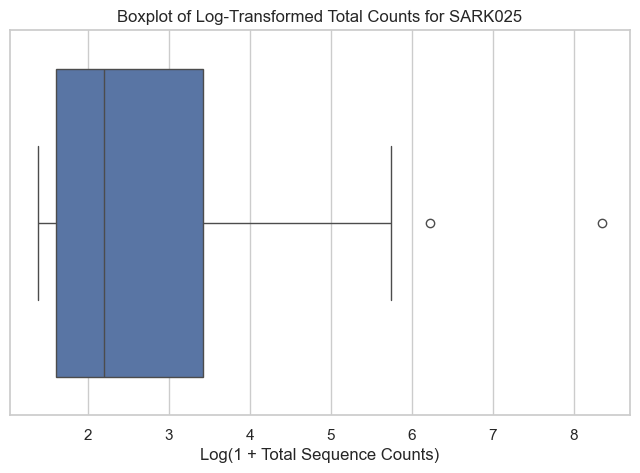

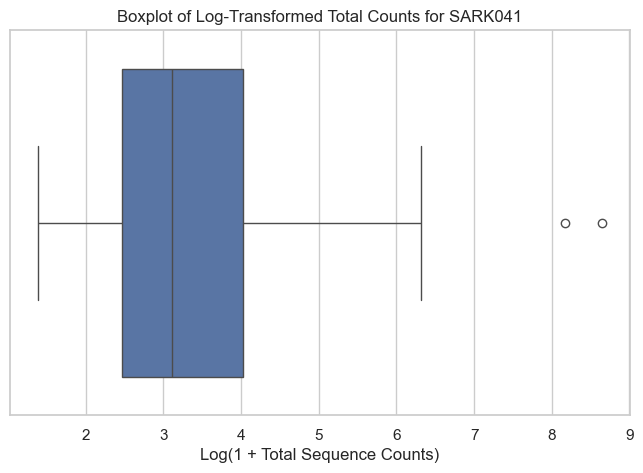

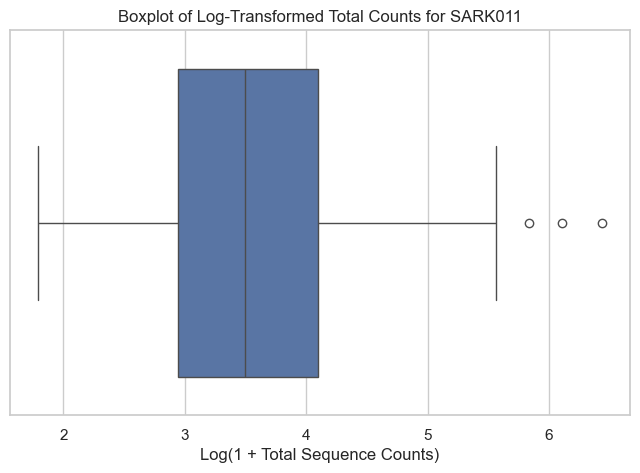

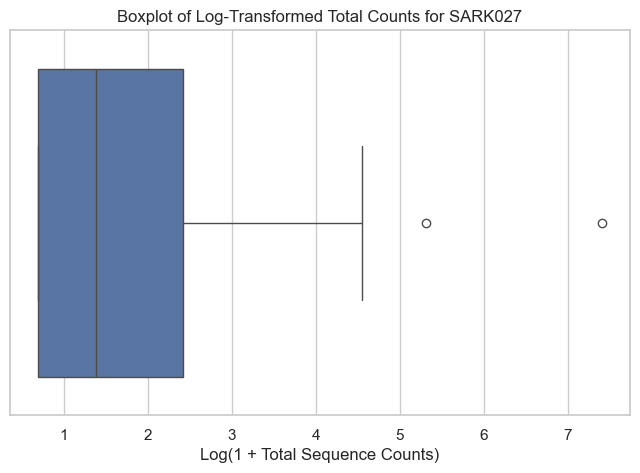

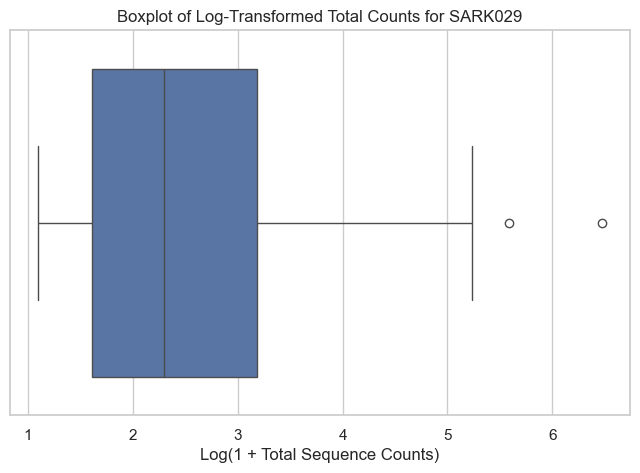

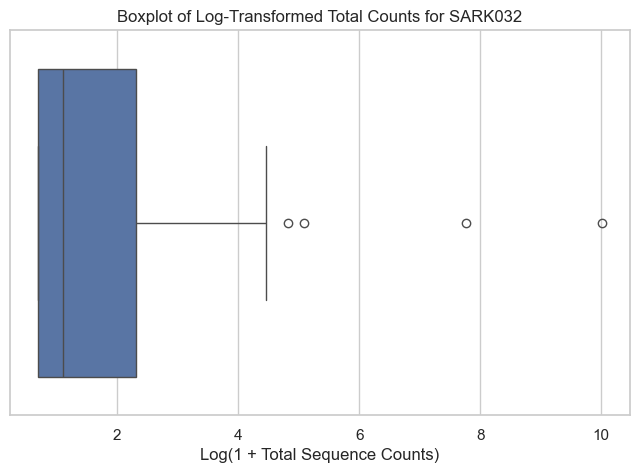

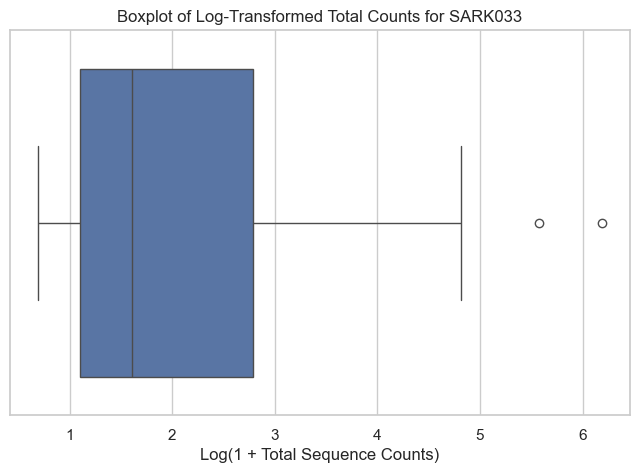

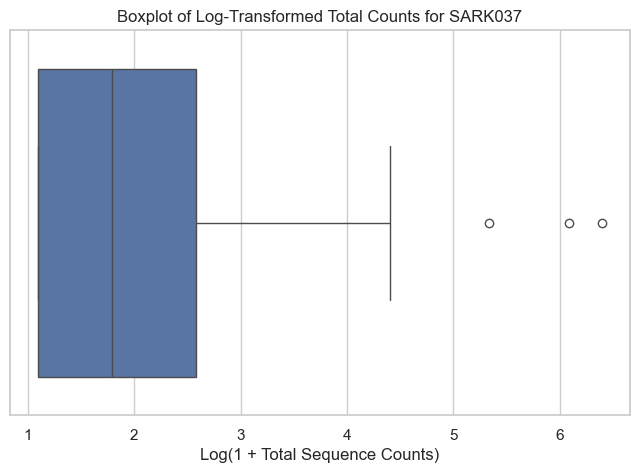

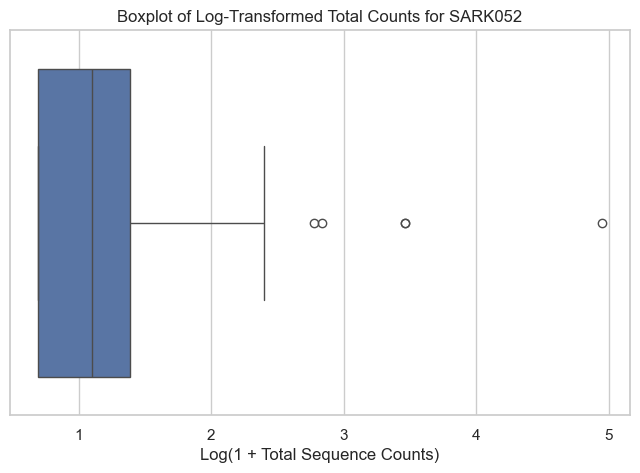

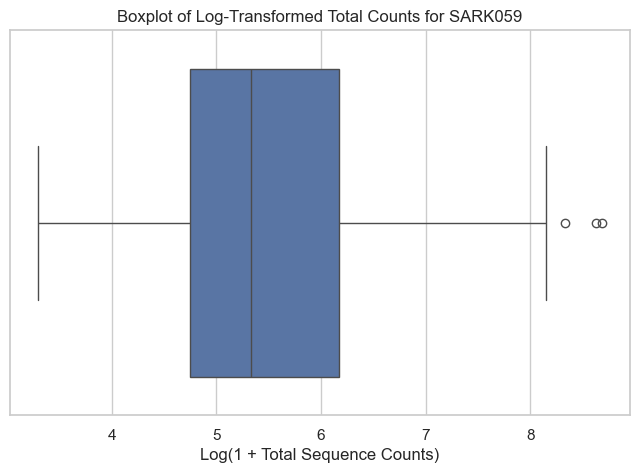

In [50]:
for pat, df in all_df.items():
    if df.empty:
        print(f"Skipping {pat} due to empty dataframe.")
        continue

    sequence_totals = df.groupby('id')['counts'].sum()

    # Boxplot with log scale
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=np.log1p(sequence_totals))  # log1p to avoid log(0) issues
    plt.xlabel("Log(1 + Total Sequence Counts)")
    plt.title(f"Boxplot of Log-Transformed Total Counts for {pat}")
    plt.show()


## Violin plot

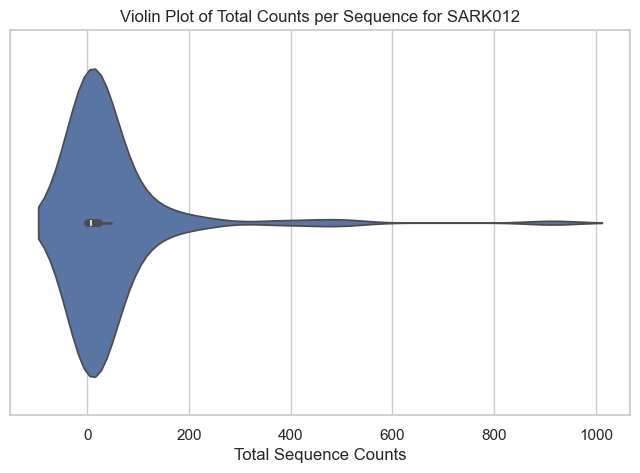

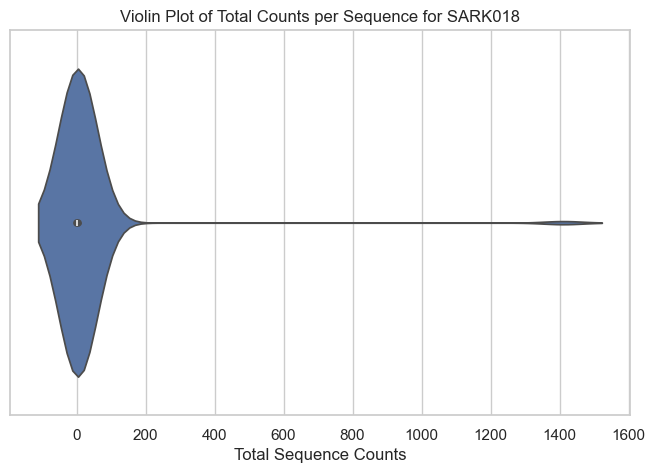

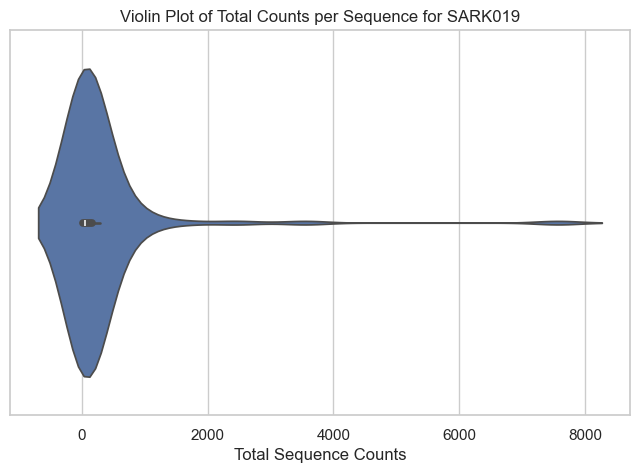

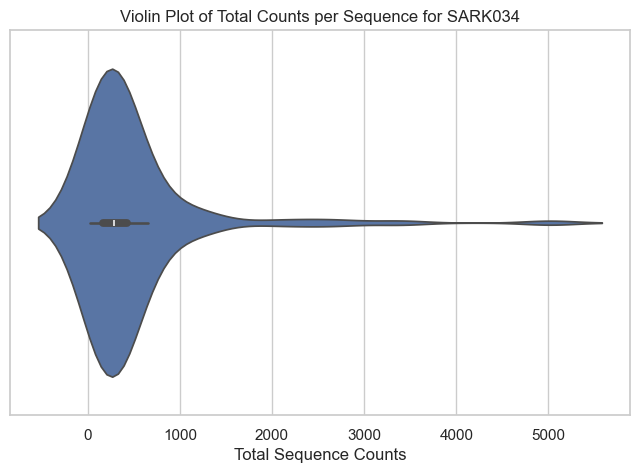

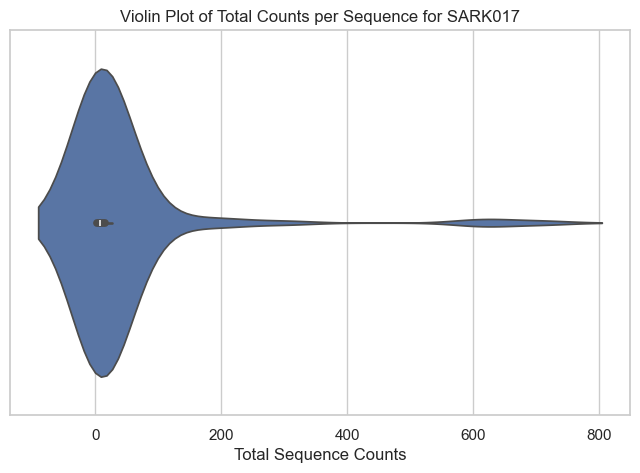

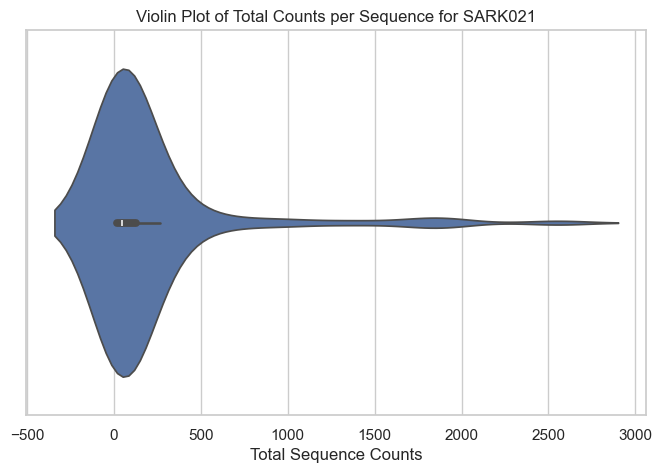

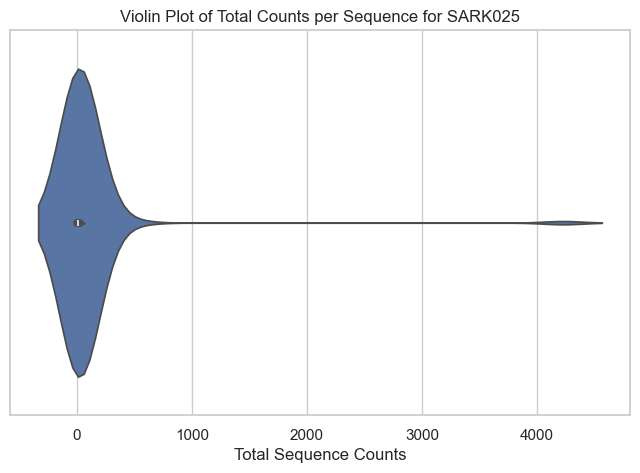

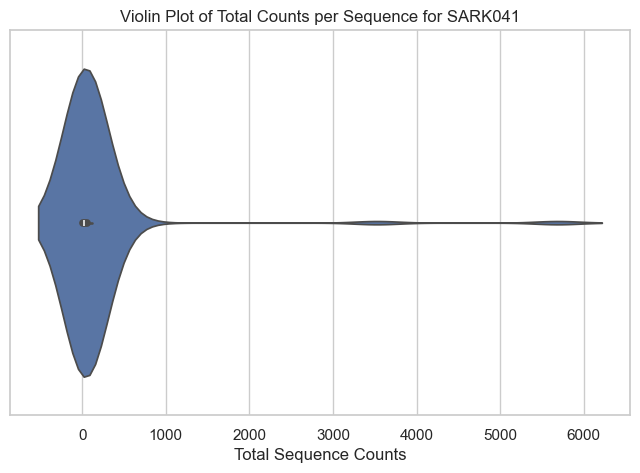

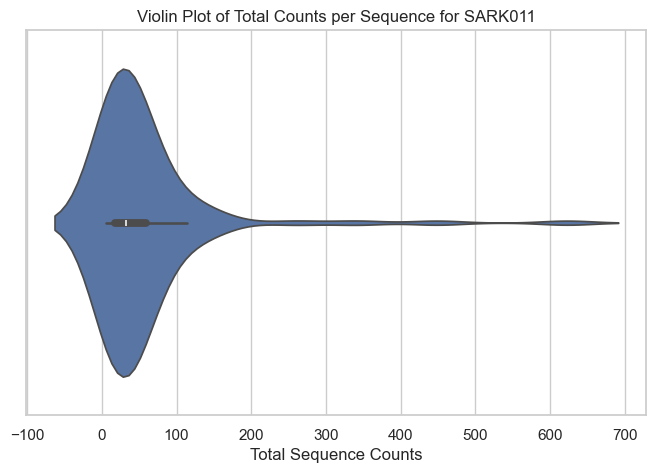

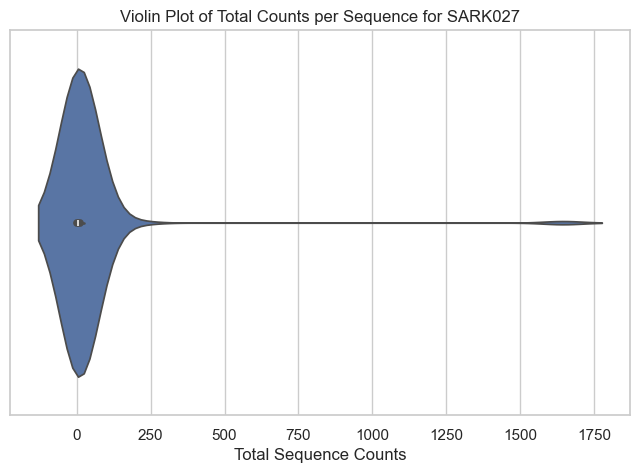

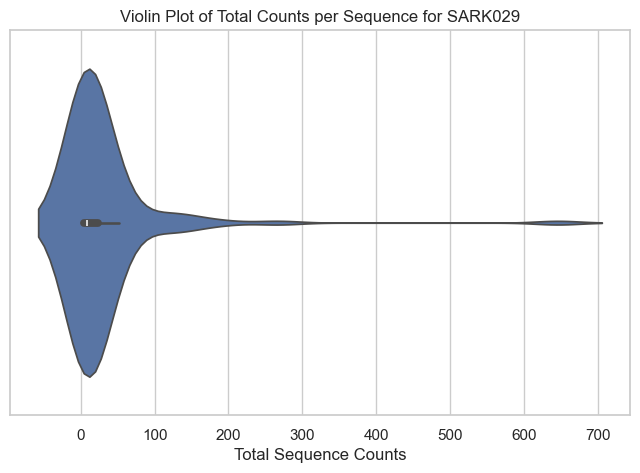

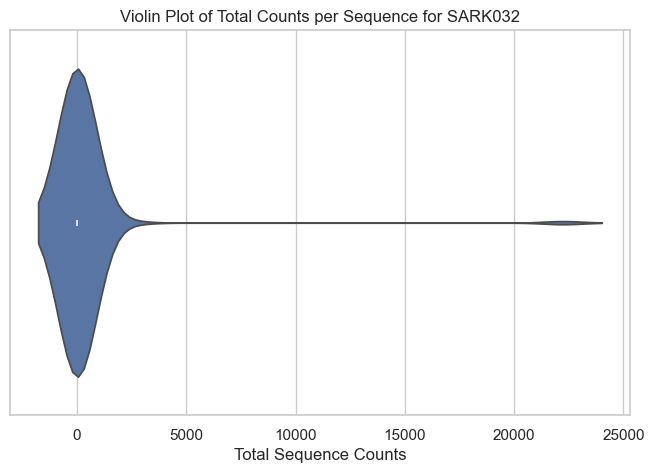

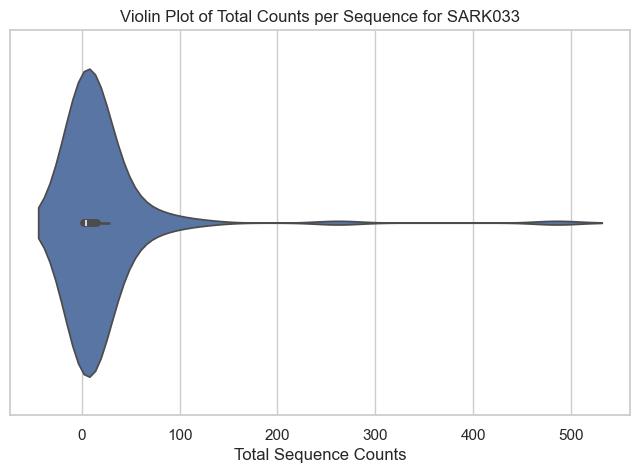

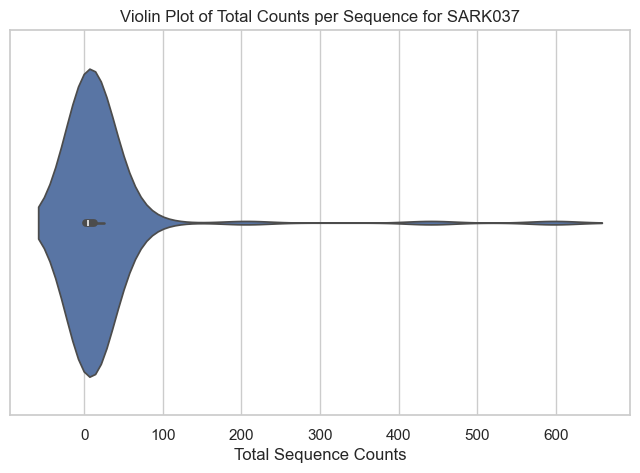

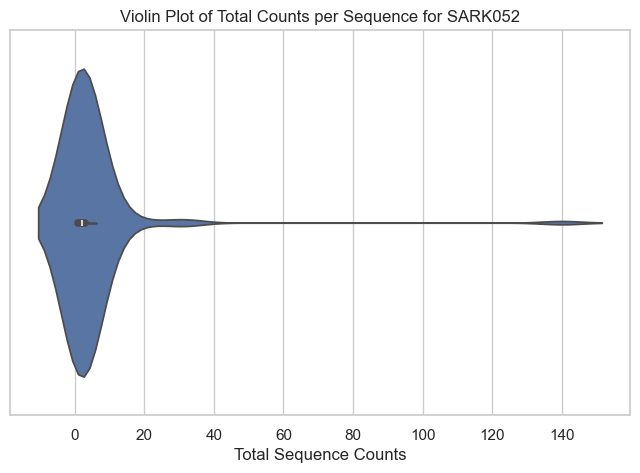

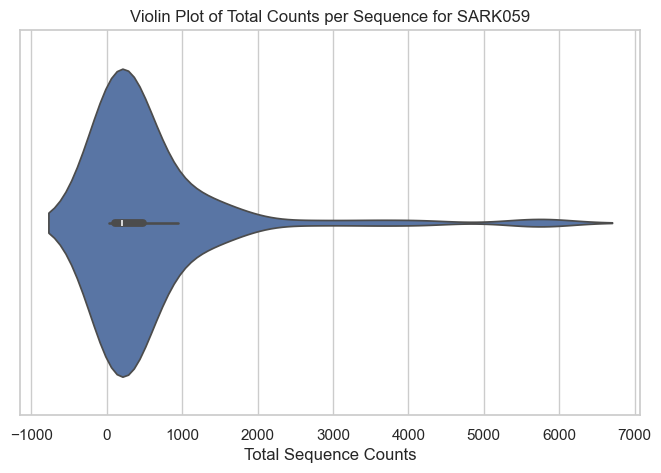

In [51]:
# Plot Histograms, Boxplots, and Violin Plots for Each Patient
for pat, df in all_df.items():
    if df.empty:
        print(f"Skipping {pat} due to empty dataframe.")
        continue

    # Sum only the 'counts' column grouped by 'id'
    sequence_totals = df.groupby('id')['counts'].sum()

    # Violin Plot
    plt.figure(figsize=(8, 5))
    sns.violinplot(x=sequence_totals)
    plt.xlabel("Total Sequence Counts")
    plt.title(f"Violin Plot of Total Counts per Sequence for {pat}")
    plt.show()


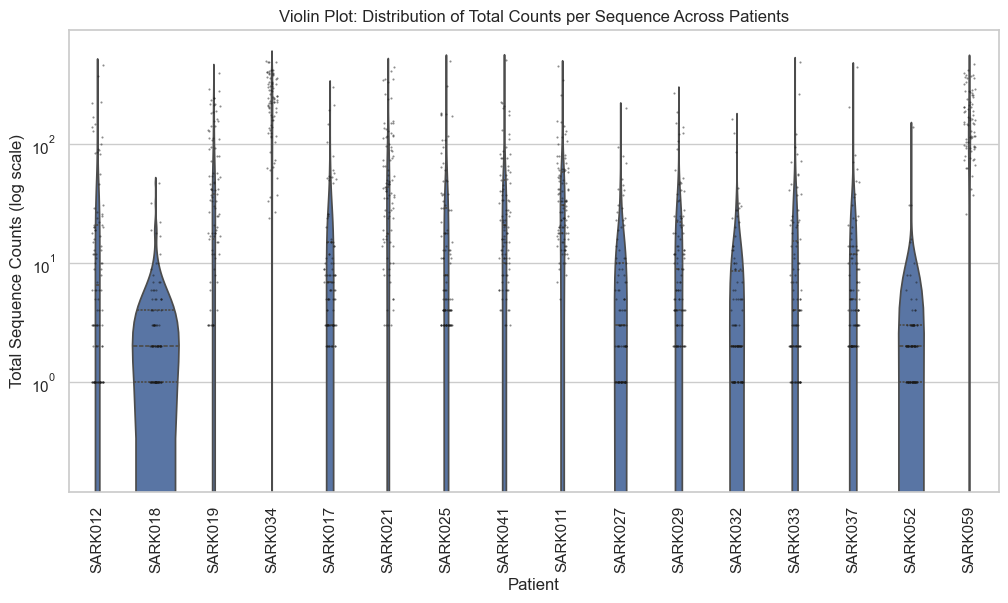

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Prepare data for violin plot
violin_data = []

for pat, df in all_df.items():
    if df.empty:
        print(f"Skipping {pat} due to empty dataframe.")
        continue

    sequence_totals = df.groupby('id')['counts'].sum()
    for value in sequence_totals:
        violin_data.append({'Patient': pat, 'Total Counts': value})

# Convert to DataFrame for Seaborn
violin_df = pd.DataFrame(violin_data)

# Remove top 5% extreme outliers for better readability
filtered_df = violin_df[violin_df['Total Counts'] < violin_df['Total Counts'].quantile(0.95)]

plt.figure(figsize=(12, 6))

# Violin plot
sns.violinplot(x='Patient', y='Total Counts', data=filtered_df, inner="quartile", split=False)

# Use stripplot instead of swarmplot to avoid placement issues
sns.stripplot(x='Patient', y='Total Counts', data=filtered_df, color="k", size=1.5, alpha=0.5, jitter=True)

plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.yscale("log")  # Log scale for better visualization
plt.xlabel("Patient")
plt.ylabel("Total Sequence Counts (log scale)")
plt.title("Violin Plot: Distribution of Total Counts per Sequence Across Patients")

plt.show()
